In [140]:
import os, sys
import numpy as np
import pandas as pd
from datetime import datetime

from matplotlib import pyplot as plt
from matplotlib import rcParams
plt.style.use('ggplot')
rcParams['figure.figsize'] = (20, 10)
%matplotlib inline
from matplotlib.image import imsave

from nilmtk.dataset_converters import convert_redd

from nilmtk import DataSet
from nilmtk.utils import print_dict

from tqdm import tqdm, tqdm_notebook

import warnings
warnings.filterwarnings(action="ignore")

from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from pyts.image import RecurrencePlot

from pyrqa.time_series import TimeSeries
from pyrqa.settings import Settings
from pyrqa.computing_type import ComputingType
from pyrqa.neighbourhood import FixedRadius
from pyrqa.metric import EuclideanMetric
from pyrqa.computation import RQAComputation

# Coleta e limpeza dos dados

In [8]:
dataset_path = "datasets/REDD/low_freq"

windows_data_path = os.path.join(dataset_path, "../../phd")
if not os.path.isdir(windows_data_path):
    os.makedirs(windows_data_path)

dataset_file = "datasets/REDD/redd.h5"
if not os.path.isfile(dataset_file):
    convert_redd(dataset_path, dataset_file)

In [9]:
redd = DataSet(dataset_file)
print_dict(redd.metadata)

In [10]:
house_3 = redd.buildings[3]
print(house_3.elec)

MeterGroup(meters=
  ElecMeter(instance=1, building=3, dataset='REDD', site_meter, appliances=[])
  ElecMeter(instance=2, building=3, dataset='REDD', site_meter, appliances=[])
  ElecMeter(instance=3, building=3, dataset='REDD', appliances=[Appliance(type='sockets', instance=1)])
  ElecMeter(instance=4, building=3, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])
  ElecMeter(instance=5, building=3, dataset='REDD', appliances=[Appliance(type='light', instance=1)])
  ElecMeter(instance=6, building=3, dataset='REDD', appliances=[Appliance(type='CE appliance', instance=1)])
  ElecMeter(instance=7, building=3, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])
  ElecMeter(instance=8, building=3, dataset='REDD', appliances=[Appliance(type='waste disposal unit', instance=1)])
  ElecMeter(instance=9, building=3, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])
  ElecMeter(instance=10, building=3, dataset='REDD', appliances=[Appliance(ty

Loading data for meter ElecMeterID(instance=13, building=3, dataset='REDD')      ElecMeterID(instance=14, building=3, dataset='REDD')     
Done loading data all meters for this chunk.


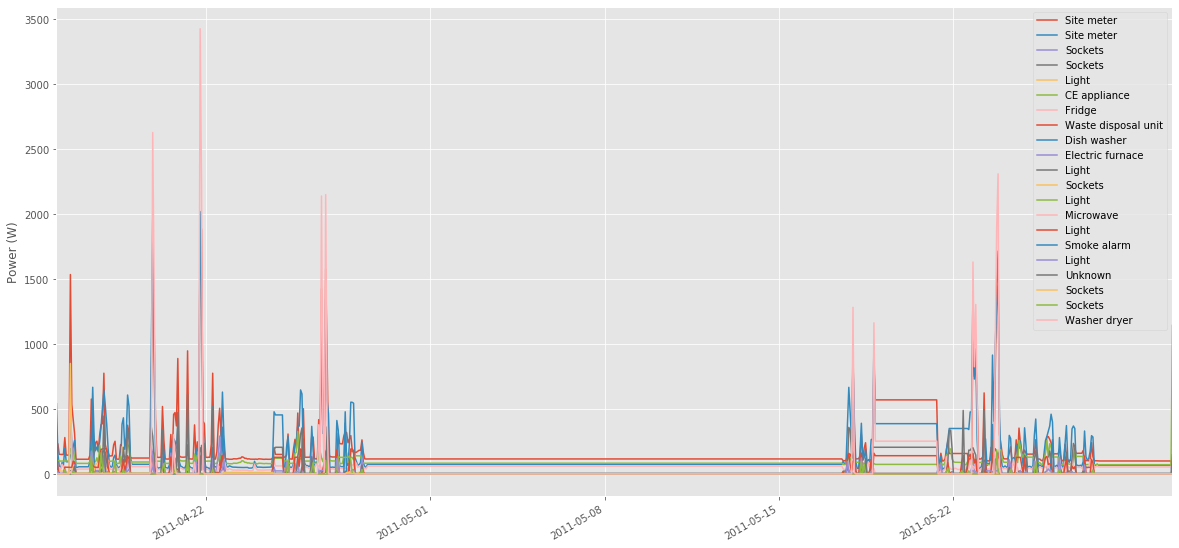

In [11]:
fig = plt.figure(figsize=(20, 10))
house_3.elec.plot();

In [12]:
# Amostras de Originais de Mains
house_3.elec.mains().power_series_all_data().head()

Loading data for meter ElecMeterID(instance=1, building=3, dataset='REDD')      ElecMeterID(instance=2, building=3, dataset='REDD')     
Done loading data all meters for this chunk.


2011-04-16 01:11:27-04:00    757.089966
2011-04-16 01:11:28-04:00    758.890015
2011-04-16 01:11:29-04:00    758.889954
2011-04-16 01:11:30-04:00    758.640015
2011-04-16 01:11:31-04:00    756.640015
Name: (power, apparent), dtype: float32

In [13]:
house_3.elec[1].power_series_all_data(sample_period=3).shape

(1290170,)

In [14]:
# Amostras de Originais de Aplpiance 3
house_3.elec[3].power_series_all_data().head()

2011-04-16 01:11:30-04:00    2.0
2011-04-16 01:11:33-04:00    1.0
2011-04-16 01:11:36-04:00    1.0
2011-04-16 01:11:40-04:00    2.0
2011-04-16 01:11:43-04:00    1.0
Name: (power, active), dtype: float32

In [15]:
house_3.elec[3].power_series_all_data(sample_period=3).shape

(1290163,)

**CONCLUSÃO PARCIAL:** É possível observar a diferenca de frequencias (mains e appliances, 1 e 3 segundos, respectivamente)

In [16]:
# Forçando taxa de 3 segundos para Mains
house_3.elec[1].power_series_all_data(sample_period=3).head()

2011-04-16 01:11:27-04:00    180.850006
2011-04-16 01:11:30-04:00    180.823334
2011-04-16 01:11:33-04:00    181.839996
2011-04-16 01:11:36-04:00    180.976669
2011-04-16 01:11:39-04:00    180.643341
Name: (power, apparent), dtype: float32

In [17]:
house_3.elec[1].power_series_all_data(sample_period=3).shape

(1290170,)

**CONCLUSÃO PARCIAL**: é possível normalizar as frequências, através do parâmetro `sample_period=SECOND_RATE`. Neste estudo, iremos `fixar esta taxa em 3 segundos`, tanto para as correntes princiais (medição geral - mains 1 e 2) quanto para os aparelhos.

Agora iremos verificar o intervalo de dados medidos, a fim de saber em quais momentos se iniciam e terminam os registros, tanto para `mains` quanto para os `appliances`.

In [18]:
sample_rate = 3

# Mains
print("Mains head: ")
display(house_3.elec[1].power_series_all_data(sample_period=sample_rate).head())
# Appliance 4
print("Appliance head: ")
display(house_3.elec[4].power_series_all_data(sample_period=sample_rate).head())

print("- "*33, "\n")
print("Mains tail:")
display(house_3.elec[1].power_series_all_data(sample_period=sample_rate).tail())

print("Appliance tail:")
display(house_3.elec[4].power_series_all_data(sample_period=sample_rate).tail())

Mains head: 


2011-04-16 01:11:27-04:00    180.850006
2011-04-16 01:11:30-04:00    180.823334
2011-04-16 01:11:33-04:00    181.839996
2011-04-16 01:11:36-04:00    180.976669
2011-04-16 01:11:39-04:00    180.643341
Name: (power, apparent), dtype: float32

Appliance head: 


2011-04-16 01:11:30-04:00    0.0
2011-04-16 01:11:33-04:00    0.0
2011-04-16 01:11:36-04:00    0.0
2011-04-16 01:11:39-04:00    0.0
2011-04-16 01:11:42-04:00    0.0
Name: (power, active), dtype: float32

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  

Mains tail:


2011-05-30 20:19:42-04:00    15.46
2011-05-30 20:19:45-04:00    15.43
2011-05-30 20:19:48-04:00    15.44
2011-05-30 20:19:51-04:00    15.47
2011-05-30 20:19:54-04:00    15.46
Name: (power, apparent), dtype: float32

Appliance tail:


2011-05-30 20:19:24-04:00    1.0
2011-05-30 20:19:27-04:00    1.0
2011-05-30 20:19:30-04:00    1.0
2011-05-30 20:19:33-04:00    1.0
2011-05-30 20:19:36-04:00    1.0
Name: (power, active), dtype: float32

**IMPORTANTE:** É possível observar algumas inconsitências quanto ao intervalo:

    1. O primeiro registro de  `mains` é anterior ao primeiro registro do `appliance;
    2. O último registro de `appliance` é anterior ao último de `mains`.
    
Neste caso, iremos deimiltar o início e o fim das medições com base no primeiro e último *timestamp* de `appliances`, sendo estes `2011-04-16 01:11:30` e `2011-05-30 20:19:36`, respectivamente.

In [19]:
redd.set_window(
    #start='2011-04-16 01:11:30', 
    #end='2011-05-30 20:19:36'
    start='2011-04-16 05:11:30',
    end='2011-04-23 08:43:26'
)
house_3 = redd.buildings[3]

In [20]:
# Mains
print("Mains head: ")
display(house_3.elec[1].power_series_all_data(sample_period=sample_rate).head())
# Appliance 4
print("Appliance head: ")
display(house_3.elec[4].power_series_all_data(sample_period=sample_rate).head())

print("- "*33, "\n")
print("Mains tail:")
display(house_3.elec[1].power_series_all_data(sample_period=sample_rate).tail())

print("Appliance tail:")
display(house_3.elec[4].power_series_all_data(sample_period=sample_rate).tail())

Mains head: 


2011-04-16 05:11:30-04:00    144.820007
2011-04-16 05:11:33-04:00    146.666672
2011-04-16 05:11:36-04:00    146.009995
2011-04-16 05:11:39-04:00    144.856674
2011-04-16 05:11:42-04:00    144.550003
Name: (power, apparent), dtype: float32

Appliance head: 


2011-04-16 05:11:33-04:00    0.0
2011-04-16 05:11:36-04:00    0.0
2011-04-16 05:11:39-04:00    0.0
2011-04-16 05:11:42-04:00    0.0
2011-04-16 05:11:45-04:00    0.0
Name: (power, active), dtype: float32

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  

Mains tail:


2011-04-23 08:43:12-04:00    132.050003
2011-04-23 08:43:15-04:00    132.035004
2011-04-23 08:43:18-04:00    130.806671
2011-04-23 08:43:21-04:00    130.459991
2011-04-23 08:43:24-04:00    130.630005
Name: (power, apparent), dtype: float32

Appliance tail:


2011-04-23 08:43:09-04:00    0.0
2011-04-23 08:43:12-04:00    0.0
2011-04-23 08:43:15-04:00    0.0
2011-04-23 08:43:18-04:00    0.0
2011-04-23 08:43:21-04:00    0.0
Name: (power, active), dtype: float32

**CONCLUSÃO PARCIAL:** Neste momento, temos uma base de dados normalizada, seguindo os parâmetros:

    * Início das medições: 16/04/2011 às 01:11:30; 
    * Início das medições: 30/05/2011 às 20:19:36 (dependendo do tamanho da janela, definido posteriormente);
    * Taxa de amostragem: 3 segundos;
    * Residência: 3.

Loading data for meter ElecMeterID(instance=13, building=3, dataset='REDD')      ElecMeterID(instance=14, building=3, dataset='REDD')     
Done loading data all meters for this chunk.


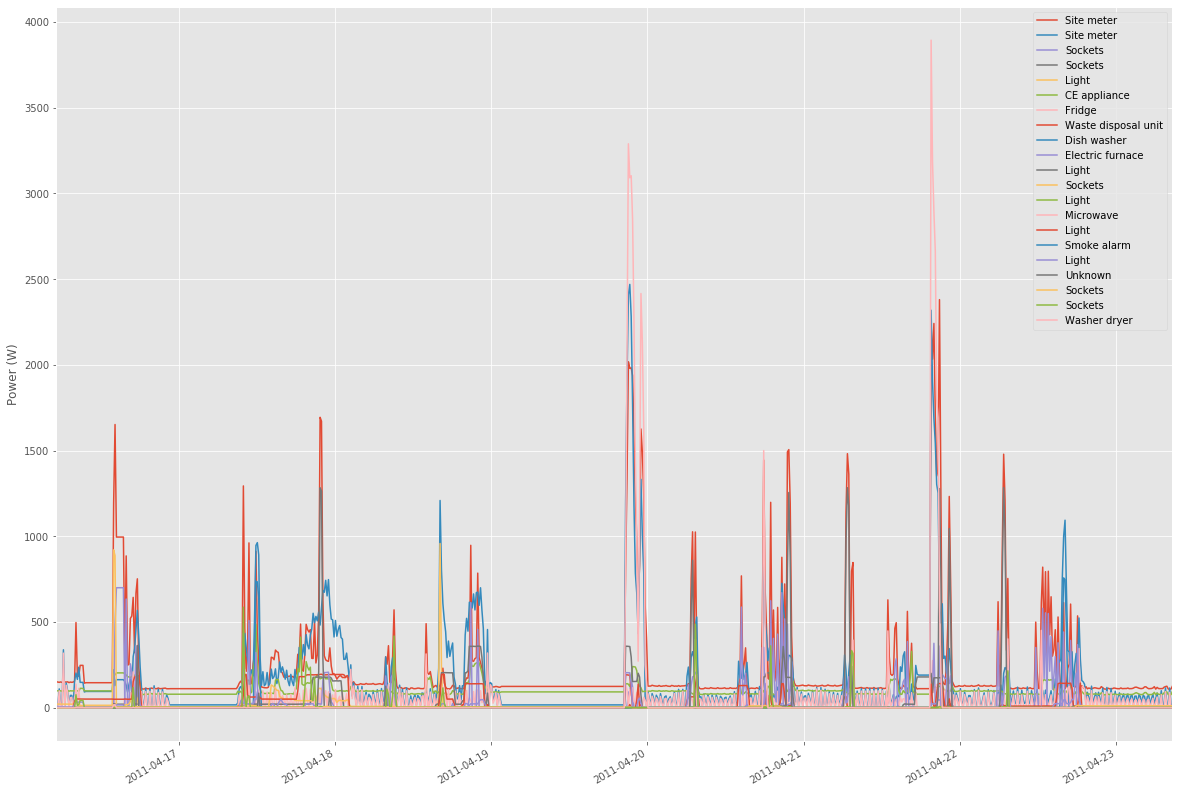

In [21]:
fig = plt.figure(figsize=(20, 15))
house_3.elec.plot();

Loading data for meter ElecMeterID(instance=13, building=3, dataset='REDD')      ElecMeterID(instance=14, building=3, dataset='REDD')     
Done loading data all meters for this chunk.


<Figure size 1440x1080 with 0 Axes>

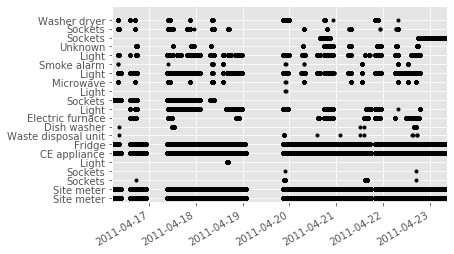

In [22]:
fig = plt.figure(figsize=(20, 15));
house_3.elec.plot_when_on();

# Preparação dos dados 
---

Com os dados normalizados, é necessário dividir as medições em janelas com submedições.

In [23]:
# Window size (5 minutes, after converted to seconds and divided by sample rate), 
# resulting in unit split of each chunk (window)

# window_length = int((1.5 * 60) / sample_rate)
window_length = int((60 * 60) / sample_rate)
window_length

1200

In [24]:
# Maximum size of series data (depending on window length)
series = house_3.elec.mains().power_series_all_data(sample_period=sample_rate)
series_limit = int(len(series.values)/window_length)*window_length
series_limit

Loading data for meter ElecMeterID(instance=1, building=3, dataset='REDD')      ElecMeterID(instance=2, building=3, dataset='REDD')     
Done loading data all meters for this chunk.


205200

In [25]:
start_timestamp = int(series.index[0].timestamp())
end_timestamp = int(series.index[series_limit].timestamp())

print("VALIDATED DATETIME INTERVAL:")
print()
print("- Initial datetime: {}".format( series.index[0].strftime(format="%d/%m/%Y %H:%M:%S") ) ) 
print("- Final datetime: {}".format( series.index[series_limit].strftime(format="%d/%m/%Y %H:%M:%S") )  )

VALIDATED DATETIME INTERVAL:

- Initial datetime: 16/04/2011 05:11:30
- Final datetime: 23/04/2011 08:11:30


In [26]:
# # Split and persist data...
# fig = plt.figure(figsize=(20,10))
# #for e in house_3.elec.all_meters():
# for e_i in range(1, len(house_3.elec.all_meters())+2):
    
#     e = house_3.elec[e_i]
#     data = np.array(e.power_series_all_data(sample_period=sample_rate).values[:series_limit])
    
#     print("Processing `{}` data ({} rows)...".format(e.label(), data.shape[0]))
    
#     # Split series in windows
#     data = data.reshape(-1, window_length)
#     # 
#     if e.label() == "Site meter":
        
#         print(data.shape)
#         np.save(
#             os.path.join(
#                 windows_data_path, 
#                 "{}-{}.npy".format(
#                     e.instance(),
#                     e.label().lower().replace(" ","_")
#                 )
#             ),
#             data
#         )
        
#     else:
#         # Appliance total energy in window
#         data = np.sum(data, axis=1)
#         np.save(
#             os.path.join(
#                 windows_data_path, 
#                 "{}-{}_total.npy".format(
#                     e.instance(),
#                     e.label().lower().replace(" ","_")
#                 )
#             ),
#             data
#         )
        
#         # ON/OFF status (1 if sum > 0 else 0)
#         data_binary = np.where(data > 0, 1, 0)
#         np.save(
#             os.path.join(
#                 windows_data_path, 
#                 "{}-{}_binary.npy".format(
#                     e.instance(),
#                     e.label().lower().replace(" ","_")
#                 )
#             ),
#             data_binary
#         )
#         plt.plot(data, label=e.label())

# plt.title("Window Power Consumption");
# plt.ylabel("Power");
# plt.legend();

**CONCLUSÃO:** Por fim, foram exportados 43.005 amostras, contemplando as janelas de 1 minuto e meio (90 segundos) de medição.

# EDA

## Plotting Power, by Appliance

In [27]:
def scale(x, out_range=(-1, 1)):
    domain = np.min(x), np.max(x)
    y = (x - (domain[1] + domain[0]) / 2) / (domain[1] - domain[0])
    return y * (out_range[1] - out_range[0]) + (out_range[1] + out_range[0]) / 2

In [28]:
def plot_serie(data, label):
    
    # Split series in windows
    #data = data.reshape(-1, window_length)
    fig, ax = plt.subplots(figsize=(20,5))
    
    # 
    if label != "Site meter":
        
        # Iterating 'windows'
#         for window in tqdm_notebook(data):
        
#         #data = np.sum(data, axis=1)
#             if sum(window) > 0:
#                 validated_windows.append(list(window))
#                 plt.plot(window, label=label)
        plt.plot(data, label=label)
#         appliances_power_windows.append({
#             "label": label,
#             "data": validated_windows
#         })
        plt.title("Power Consumption - " + label);
        plt.ylabel("Power");
        plt.xlim(0, len(data)-1);
#         plt.xticks(np.arange(0, len(data), 100), rotation='vertical');
#         plt.xlim(0, window_length-1);
        #plt.xticks(list(range(0, window_length*3, 3)))
        plt.show();

### RPs from Usage Appliances (When ON intervals only)

`Sockets` original size: 205837 dimensions


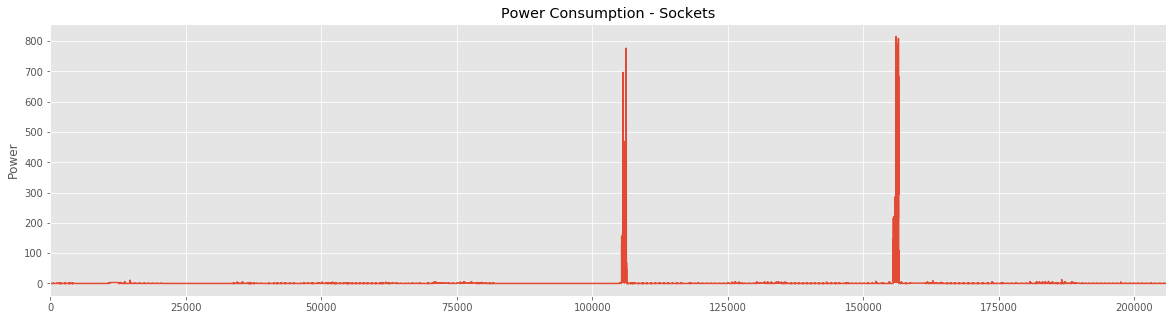

`Sockets` original size: 205837 dimensions
---> Sockets WARNING: Series dimension `WHEN ON` (3) is lower than RP time_delay (8)


`Light` original size: 205837 dimensions


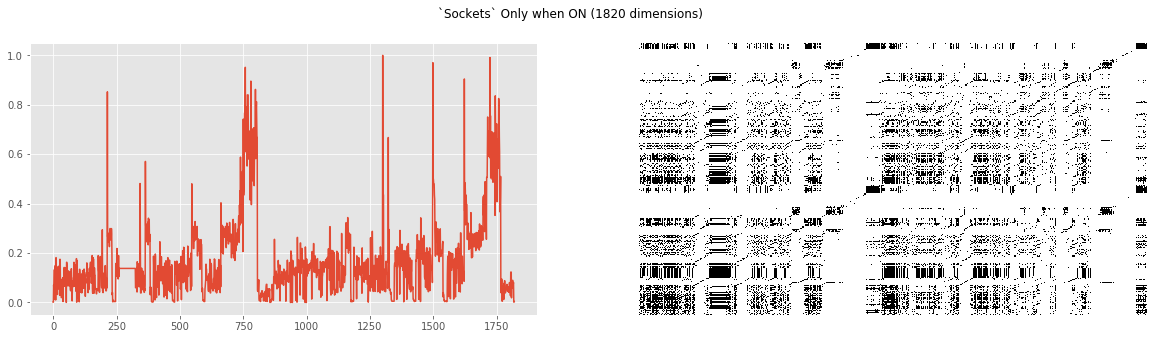

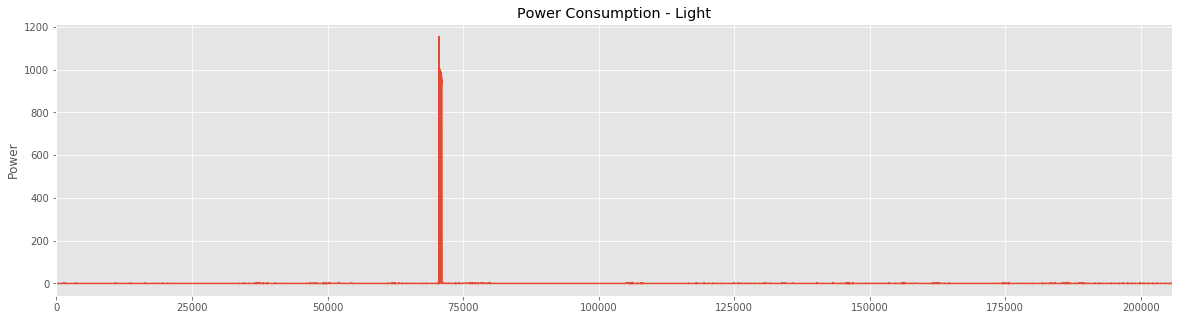

`CE appliance` original size: 205837 dimensions


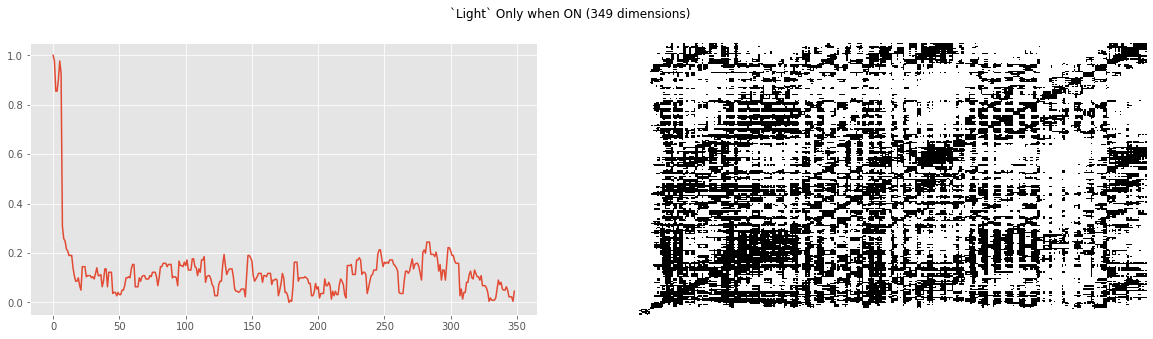

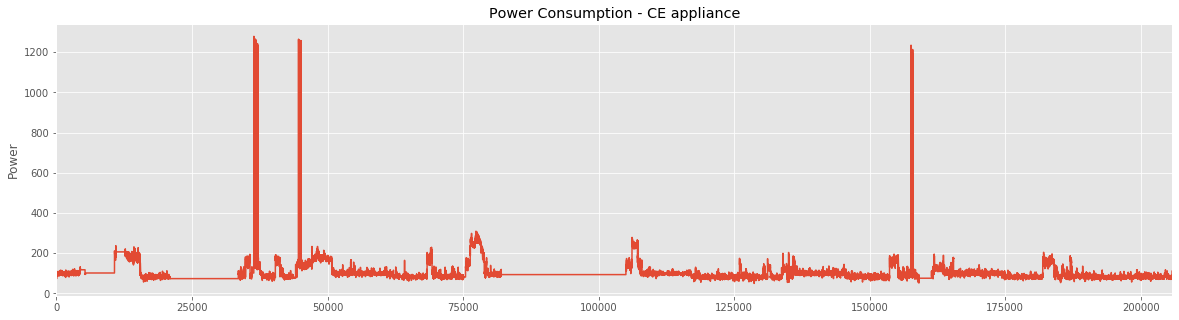

`Fridge` original size: 205837 dimensions


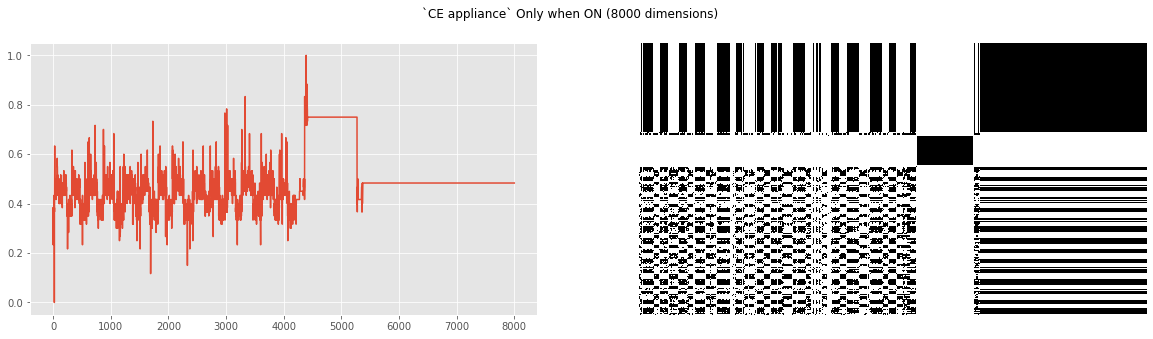

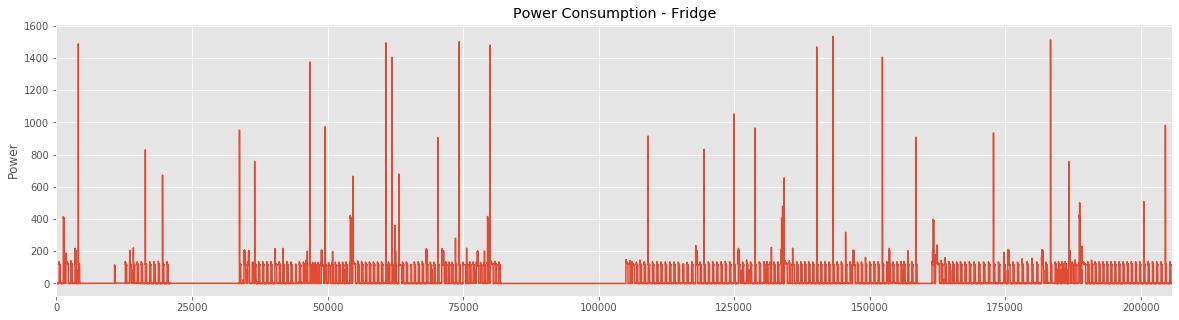

`Waste disposal unit` original size: 205837 dimensions


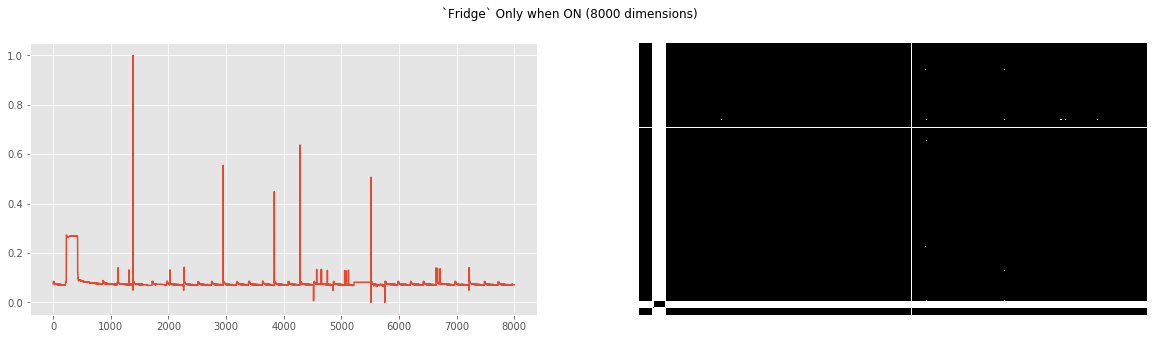

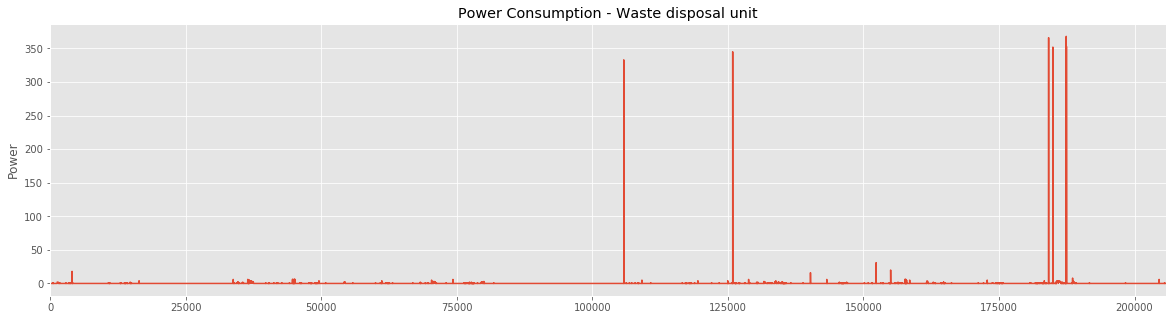

`Dish washer` original size: 205837 dimensions


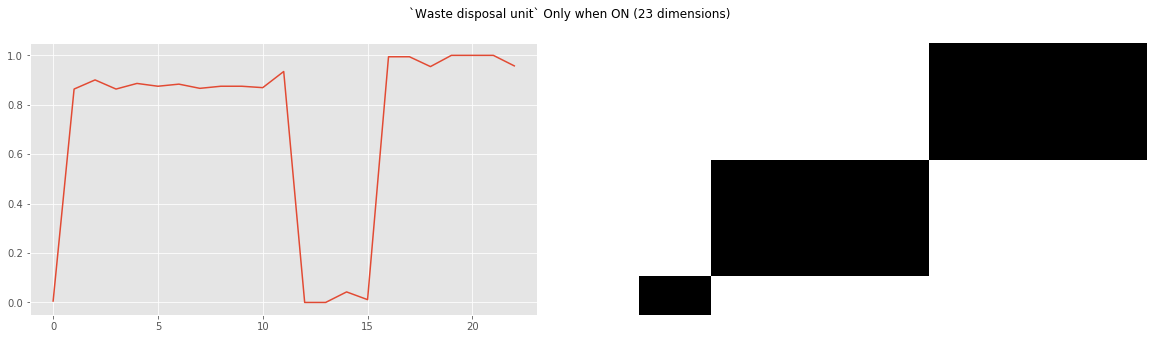

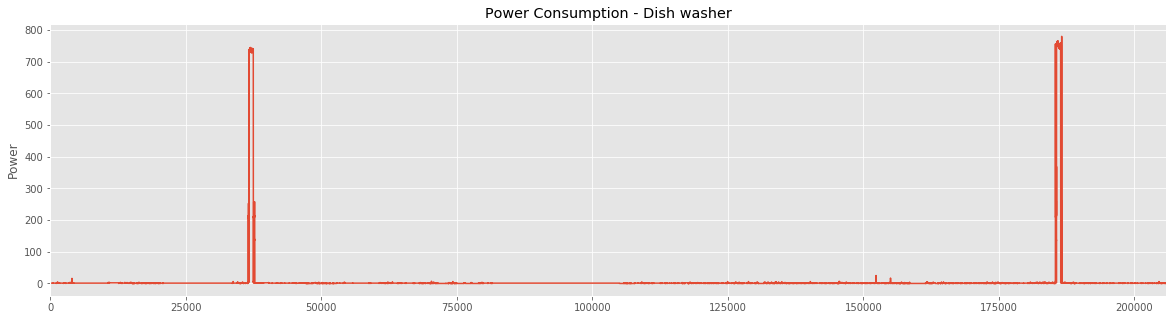

`Electric furnace` original size: 205837 dimensions


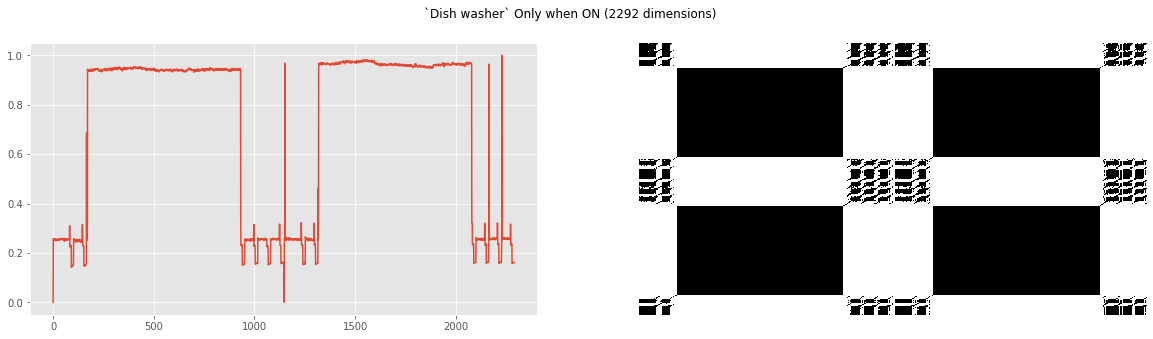

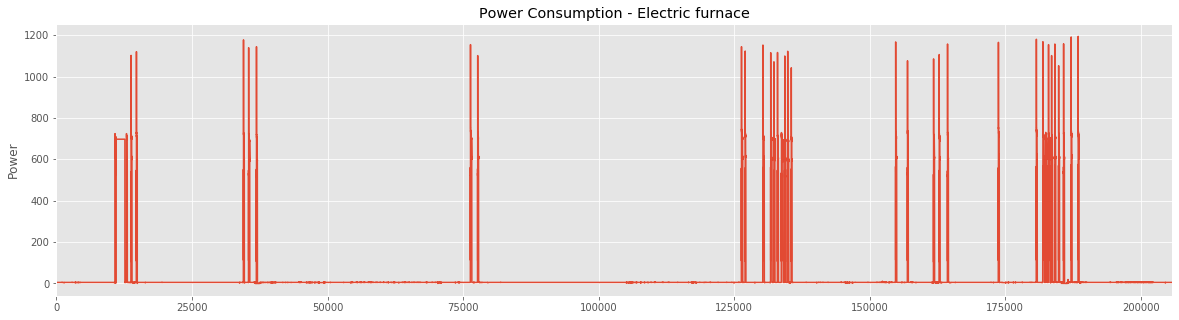

`Light` original size: 205837 dimensions


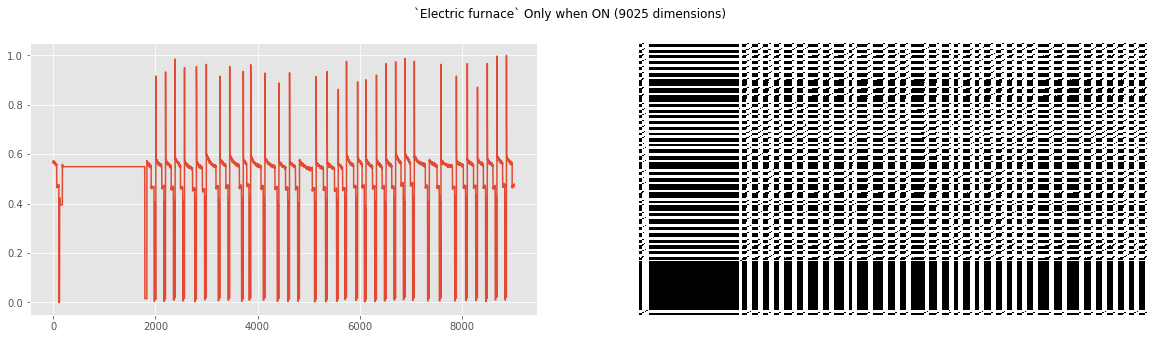

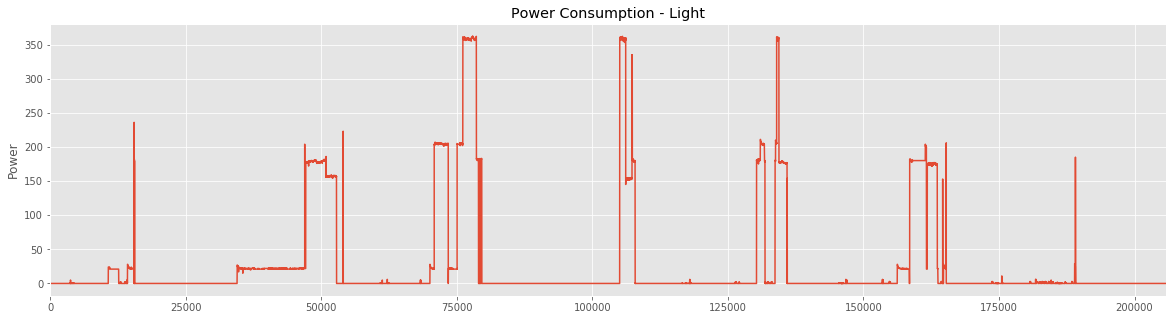

`Sockets` original size: 205837 dimensions


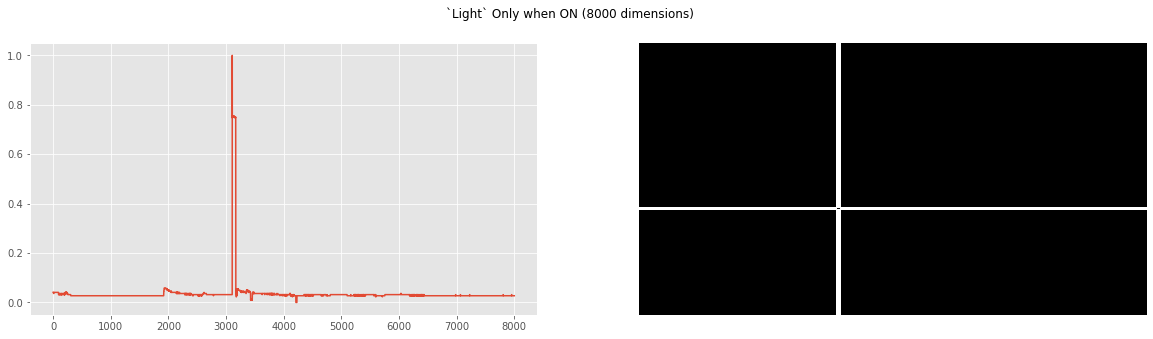

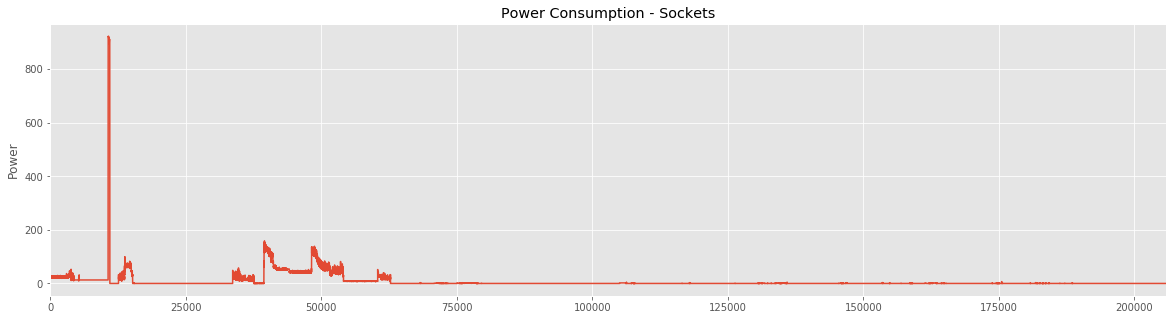

`Light` original size: 205837 dimensions
---> Light WARNING: Series dimension `WHEN ON` (4) is lower than RP time_delay (8)


`Microwave` original size: 205837 dimensions


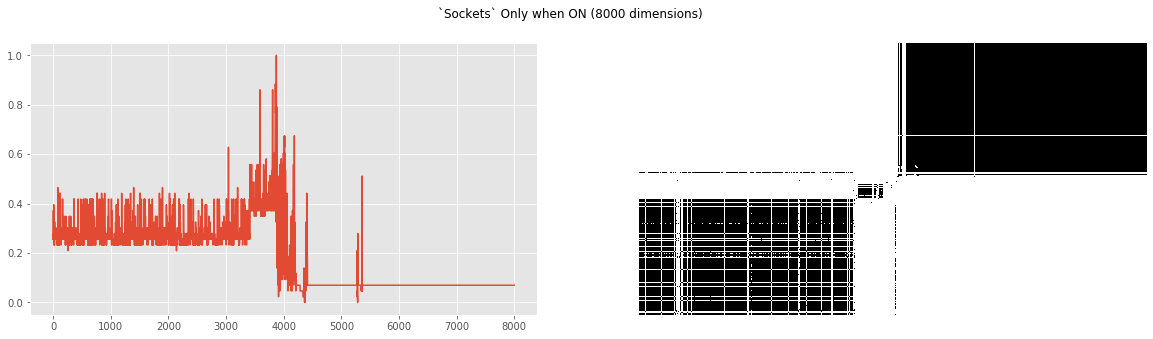

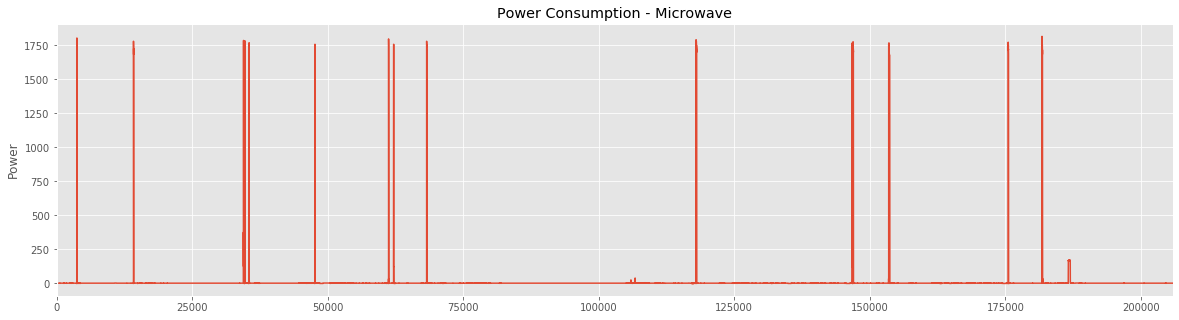

`Light` original size: 205837 dimensions


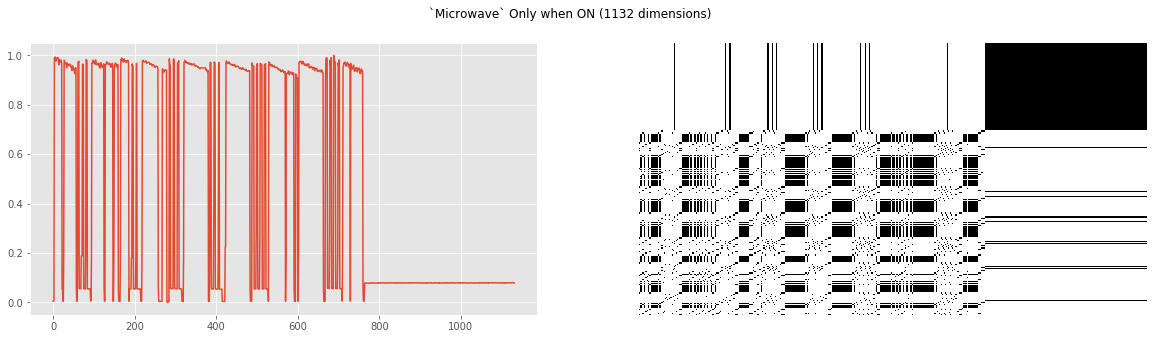

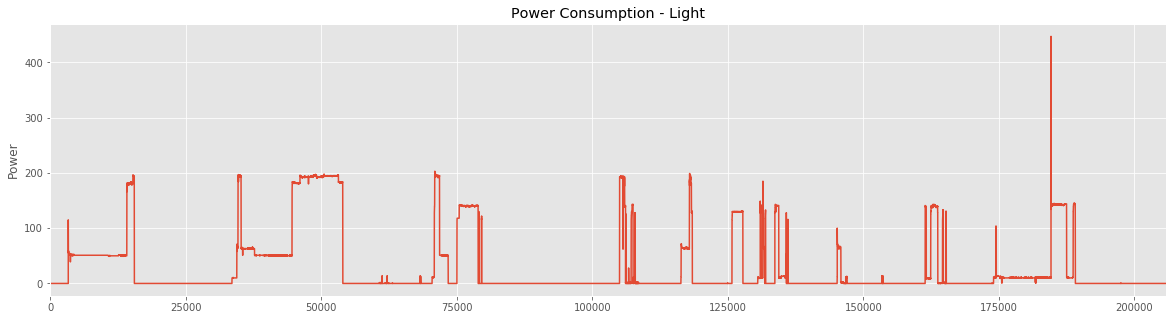

`Smoke alarm` original size: 205837 dimensions


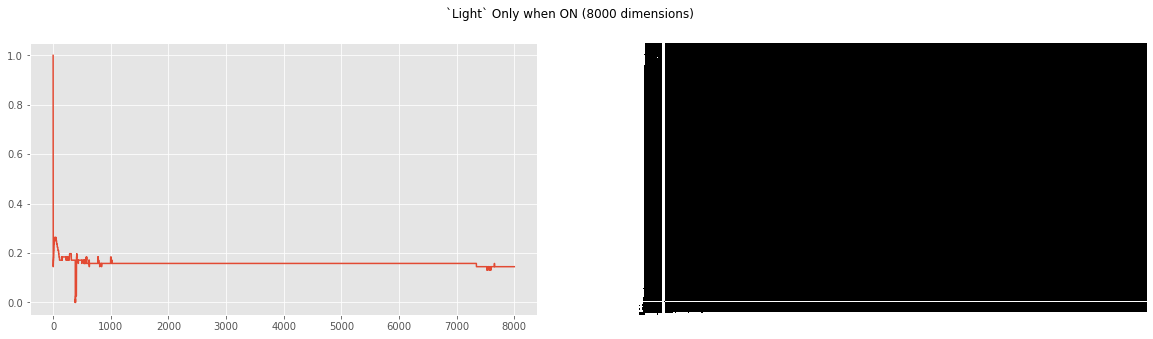

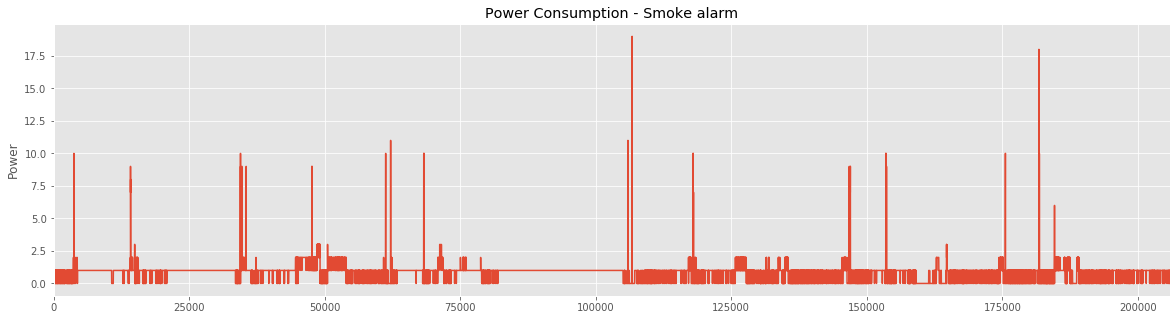

`Light` original size: 205837 dimensions


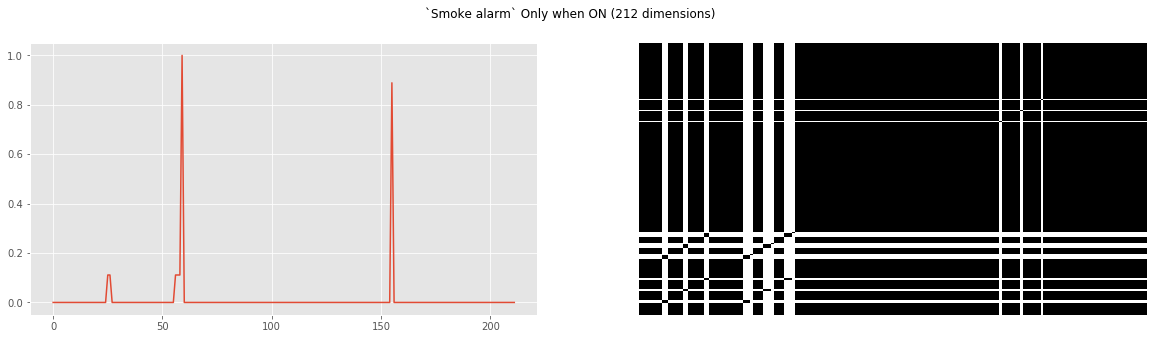

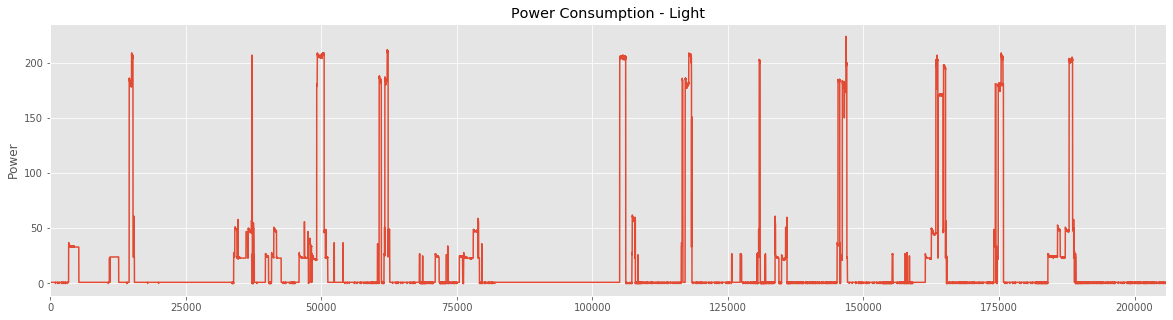

`Unknown` original size: 205837 dimensions


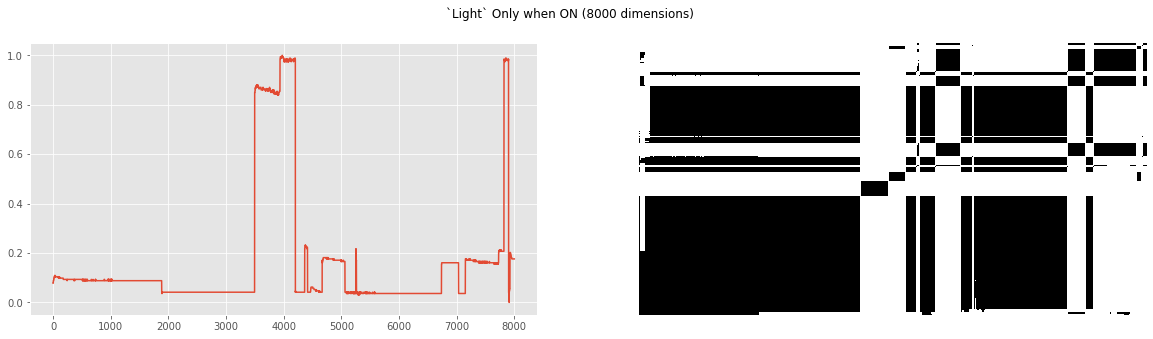

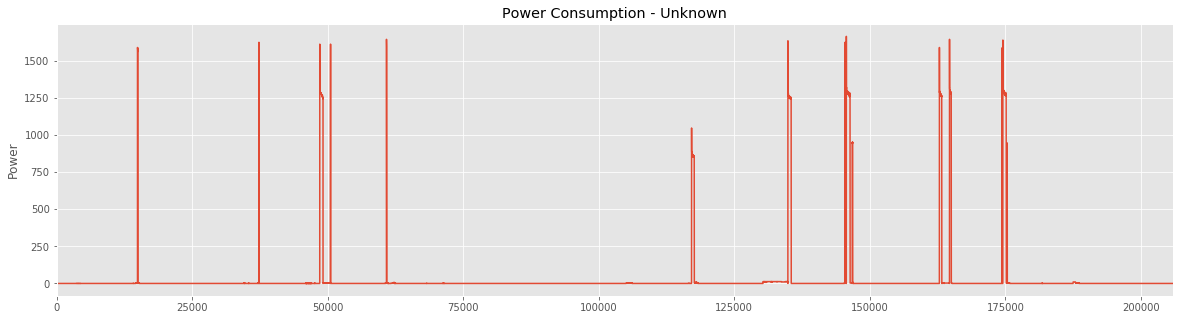

`Sockets` original size: 205837 dimensions


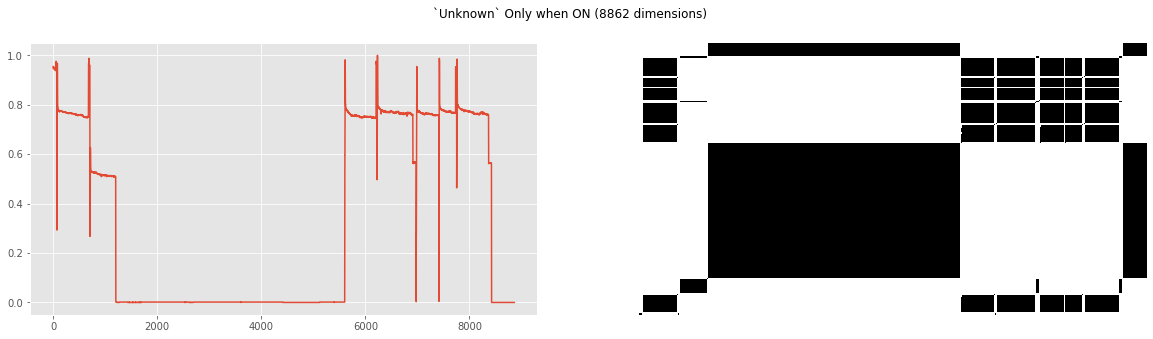

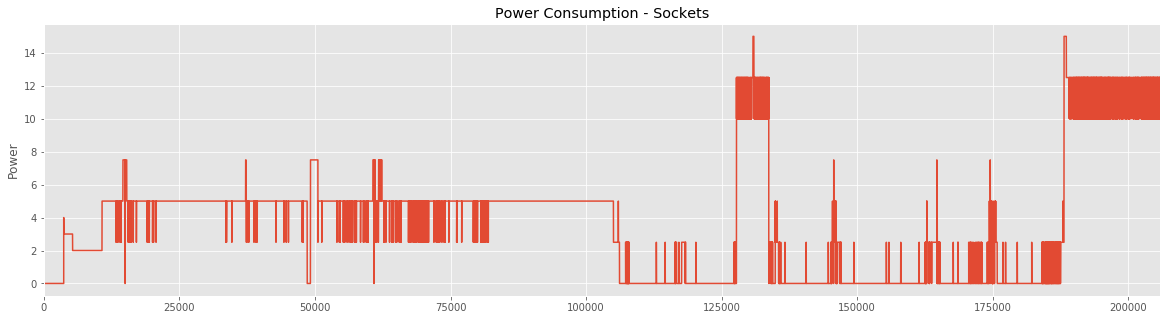

`Sockets` original size: 205837 dimensions


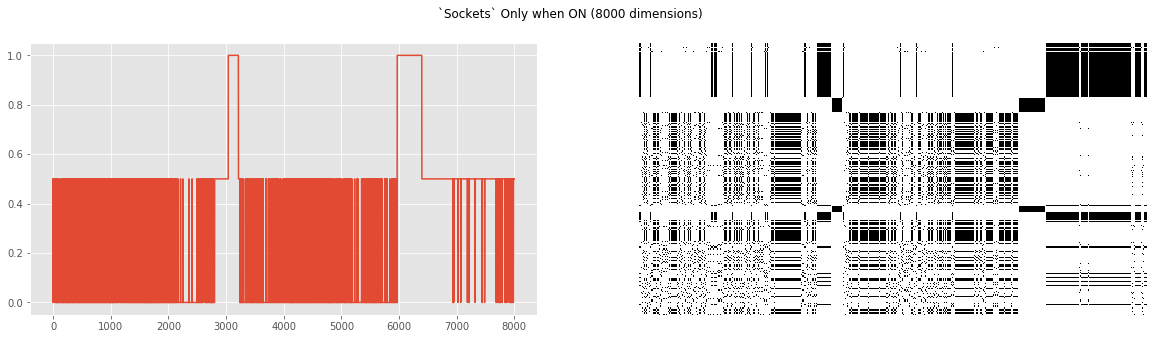

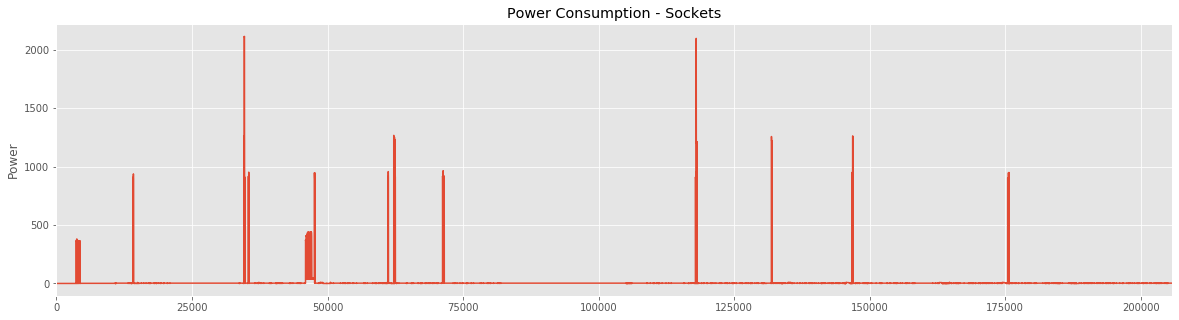

Loading data for meter ElecMeterID(instance=13, building=3, dataset='REDD')      ElecMeterID(instance=14, building=3, dataset='REDD')     
Done loading data all meters for this chunk.
`Washer dryer` original size: 205839 dimensions
Loading data for meter ElecMeterID(instance=13, building=3, dataset='REDD')      ElecMeterID(instance=14, building=3, dataset='REDD')     
Done loading data all meters for this chunk.


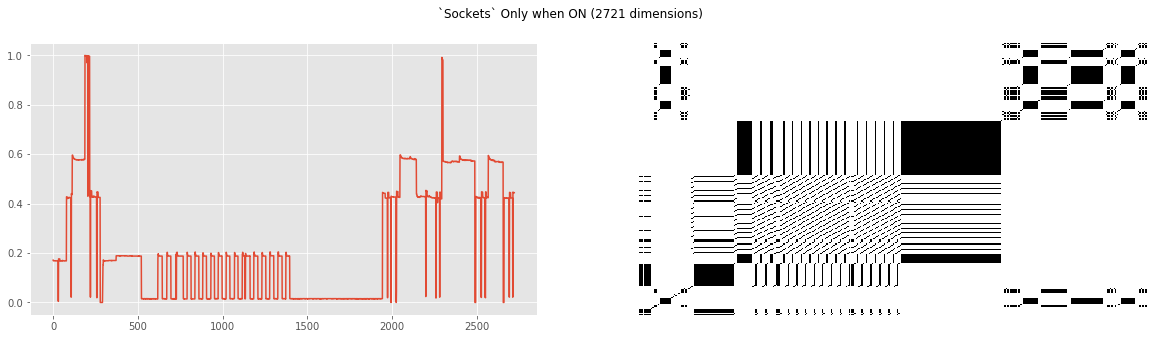

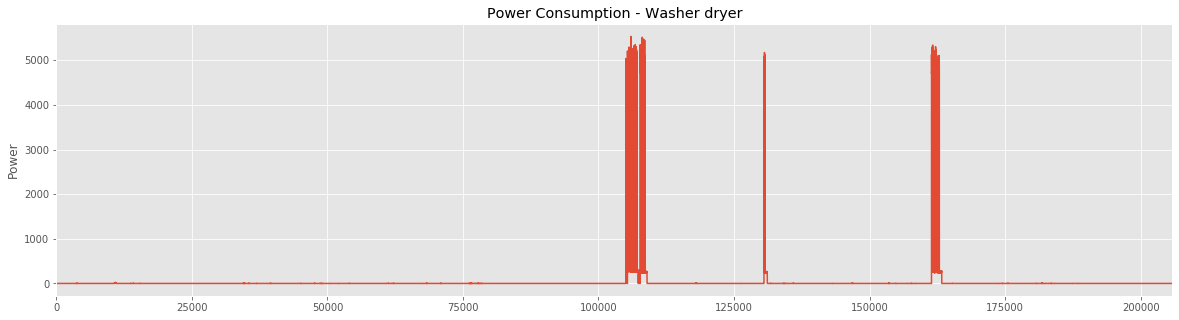

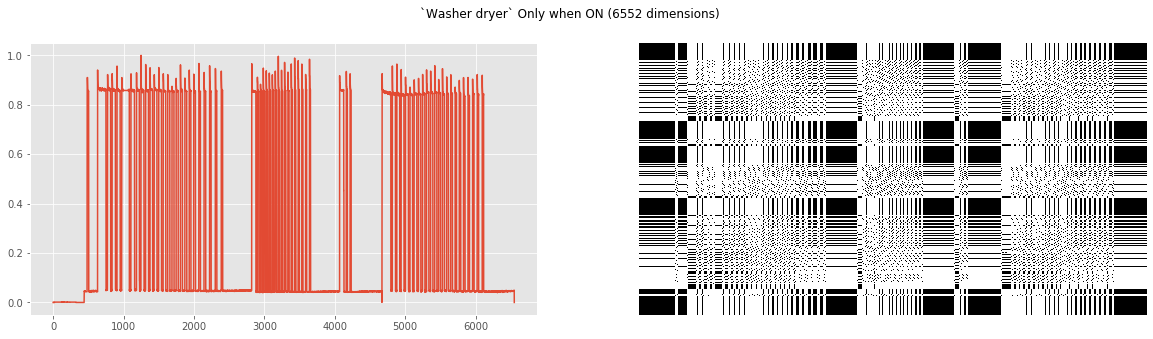

In [35]:
appliances_power = []
appliances_power_ON = []

rp_params = {
    "dimension": 3,
    "time_delay": 8,
    "threshold": 0.1
}
for e in house_3.elec.submeters().meters:

    power = e.power_series_all_data(sample_period=sample_rate)
    appliances_power.append(power)
    print("`{}` original size: {} dimensions".format(e.label(), power.shape[0]))

    when_on = next(e.when_on(sample_period=sample_rate))
    power_on = power[when_on == True].values
    power_on = np.where(np.isnan(power_on), 0, power_on)
    #print("`{}` WHEN ON size: {} dimensions".format(e.label(), power_on.shape[0]))
    #plot_serie(power_on, e.label()+" (when ON)")
    if len(power_on) >= rp_params["time_delay"]:
        if len(power_on) > 10000:#< int(series_limit/10): # >= Dimension RP AND <> max_len (not allocate memory error)
            power_on = power_on[:8000]

        # Original serie
        plot_serie(power.values, e.label())

        # Power ON
        power_on = scale(power_on, out_range=(0, 1)) if np.var(power_on) > 0 else power_on / max(power_on)#scale(power_on, out_range=(0, 1))
        appliances_power_ON.append(power_on)

        rp_image = RecurrencePlot(
                        dimension  = rp_params["dimension"],
                        time_delay = rp_params["time_delay"],
                        threshold  = rp_params["threshold"], # Limiar de recorrencia
                    ).fit_transform([power_on])[0]#(X.values)[0]

        fig = plt.figure(figsize=(20,5))
        fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

        ax = fig.add_subplot(1, 2, 1)
        plt.plot(list(range(0, power_on.shape[0])), power_on)
        #plt.xlim(0, window_length-1)
        ax = fig.add_subplot(1, 2, 2)
        ax.imshow(rp_image, origin="lower", aspect="auto", cmap="binary")

        plt.axis('off')

        fig.suptitle("`{}` Only when ON ({} dimensions)".format(e.label(), power_on.shape[0]))
#         else:
#             print("---> {} WARNING: {}".format(e.label(), "High dimensionality `WHEN ON` ("+str(len(power_on))+")\n\n"))
    else:
        print("---> {} WARNING: {}".format(e.label(), "Series dimension `WHEN ON` ("+str(len(power_on))+") is lower than RP time_delay ("+str(rp_params["time_delay"])+")\n\n"))

In [54]:
# joblib.dump(appliances_power, os.path.join(windows_data_path, "appliances_power_ipynb14.pkl"))

['datasets/REDD/low_freq\\../../phd\\appliances_power_ipynb14.pkl']

In [57]:
import pickle
PIK = os.path.join(windows_data_path, "appliances_power_ON_ipynb14.dat")
with open(PIK, "wb") as f:
    pickle.dump(appliances_power_ON, f)

In [58]:
series_limit

205200

### RPs from Windows Consumption

**References:**
    1. https://arxiv.org/pdf/1007.2215.pdf (RP Hyperparameter insights)
    2. https://arxiv.org/ftp/cond-mat/papers/0412/0412765.pdf (Phase-space reconstruction)
    3. https://acervodigital.ufpr.br/bitstream/handle/1884/17165/tese-everton.pdf?sequence=1&isAllowed=y
    4. http://pepsic.bvsalud.org/pdf/rbcdh/v29n1/pt_06.pdf
    5. http://propi.ifto.edu.br/ocs/index.php/connepi/vii/paper/viewFile/1457/2488

In [162]:
rp_params = {
    "dimension": 3,
    "time_delay": 8,
    "threshold": 0.1
}

columns_rqa = [
    "Minimum diagonal line length (L_min)",
    "Minimum vertical line length (V_min)",
    "Minimum white vertical line length (W_min)",
    "Recurrence rate (RR)",
    "Determinism (DET)",
    "Average diagonal line length (L)",
    "Longest diagonal line length (L_max)",
    "Divergence (DIV)",
    "Entropy diagonal lines (L_entr)",
    "Laminarity (LAM)",
    "Trapping time (TT)",
    "Longest vertical line length (V_max)",
    "Entropy vertical lines (V_entr)",
    "Average white vertical line length (W)",
    "Longest white vertical line length (W_max)",
    "Longest white vertical line length inverse (W_div)",
    "Entropy white vertical lines (W_entr)",
    "Ratio determinism / recurrence rate (DET/RR)",
    "Ratio laminarity / determinism (LAM/DET)"
]

rqa_data = []

images_path = os.path.join(windows_data_path, "rp_analysis")
if not os.path.isdir(images_path):
    os.makedirs(images_path)
    
# Turn interactive plotting off
plt.ioff()
    
# for i, e in tqdm_notebook(enumerate(house_3.elec.submeters().meters)):
for e_i in tqdm_notebook(range(1, len(house_3.elec.all_meters())+2)):
    
    e = house_3.elec[e_i]
    
    appliance_images_path = os.path.join(images_path, str(e.instance())+"-"+e.label().lower().replace(" ","_"))
    if not os.path.isdir(appliance_images_path):
        os.makedirs(appliance_images_path)        
    
    power = np.array(e.power_series_all_data(sample_period=sample_rate).values[:series_limit])
    #data = np.array(power.values)
#     data = np.where(np.isnan(power), 0, power)
    data = power.reshape(-1, window_length)

    # Iterating over the windows, for random select a sample
    w = 0
    for window in data:
        
        window = np.nan_to_num(window.tolist())
        window = scale(window, out_range=(0, 1)) if np.var(window) > 0 else window / max(window)#scale(window, out_range=(0, 1))
        
        if sum(window) > 0 and sum(window) < len(window) and np.isnan(sum(window)) == False:
            
            image_path = os.path.join( appliance_images_path, "{}.png".format(w) )

            if not os.path.isfile(image_path):

                rp_image = RecurrencePlot(
                                dimension  = rp_params["dimension"],
                                time_delay = rp_params["time_delay"],
                                threshold  = rp_params["threshold"], # Limiar de recorrencia
                            ).fit_transform([window])[0]#(X.values)[0]

                fig = plt.figure(figsize=(20,5))
                fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

                ax = fig.add_subplot(1, 2, 1)
                plt.plot(list(range(0, window.shape[0])), window)
                #plt.xlim(0, window_length-1)
                ax = fig.add_subplot(1, 2, 2)
                ax.imshow(rp_image, origin="lower", aspect="auto", cmap="binary")

                plt.axis('off')

                fig.suptitle("`{}` ({} dimensions)".format(e.label(), window.shape[0]))

                plt.savefig(image_path, bbox_inches='tight')
                plt.close(fig)
            
            # Calculating RQA
            time_series = TimeSeries(window,
                         embedding_dimension=rp_params["dimension"],
                         time_delay=rp_params["time_delay"])
            settings = Settings(time_series,
                                computing_type=ComputingType.Classic,
                                neighbourhood=FixedRadius(rp_params["threshold"]),
                                similarity_measure=EuclideanMetric)
            computation = RQAComputation.create(settings, verbose=False)
            rqa_result = computation.run()
            
            
            rqa_data.append( [e.label(), w] + list(rqa_result.to_array()) )

            w += 1

Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.


Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.


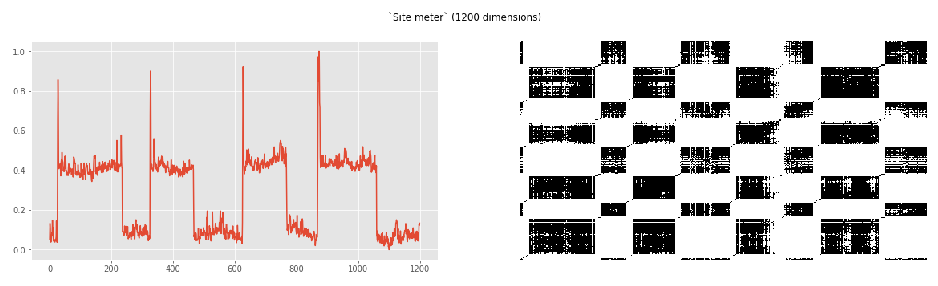

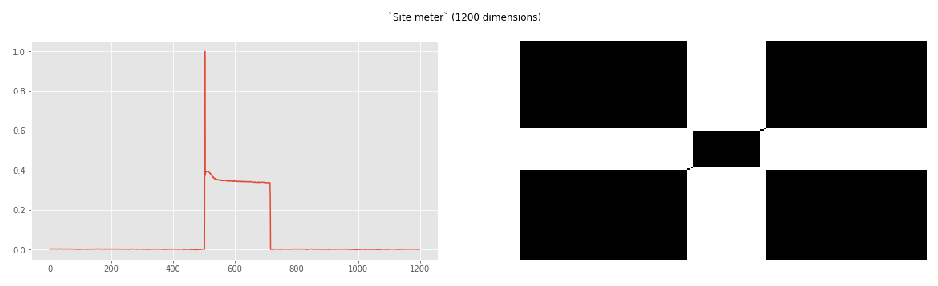

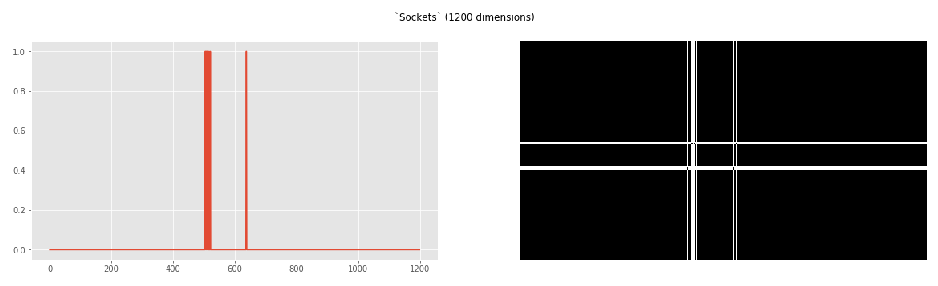

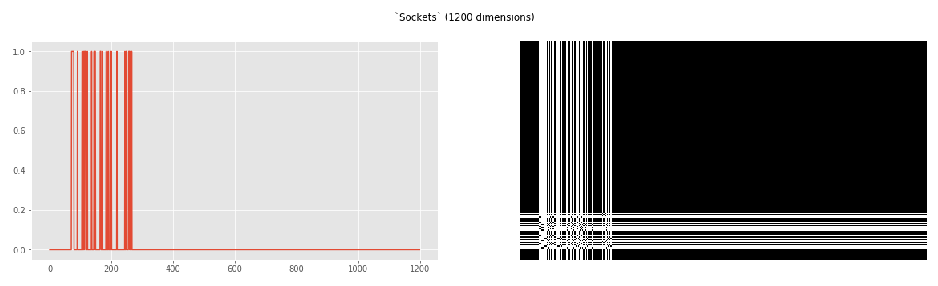

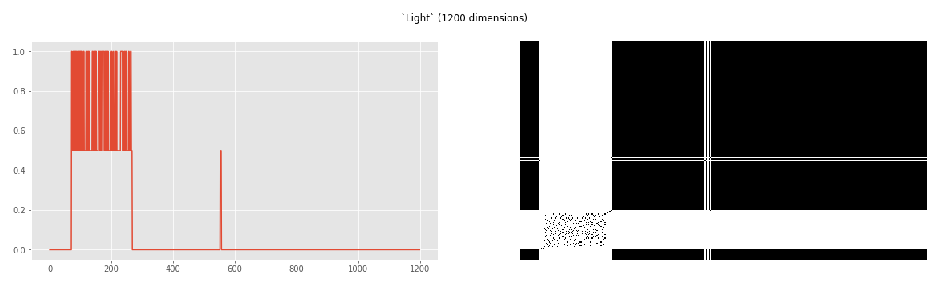

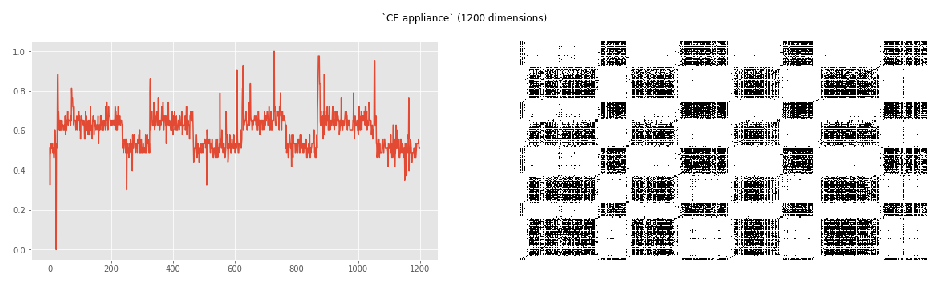

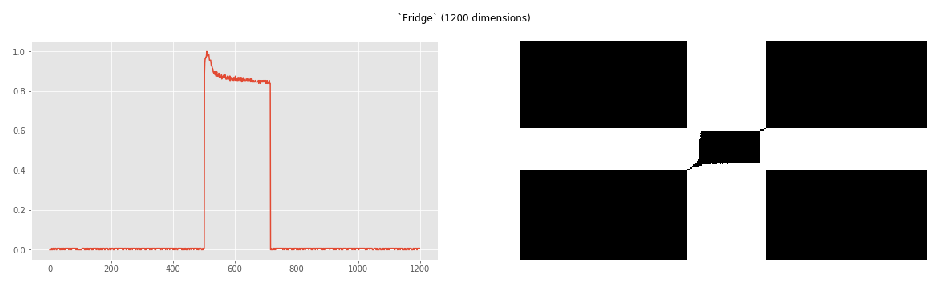

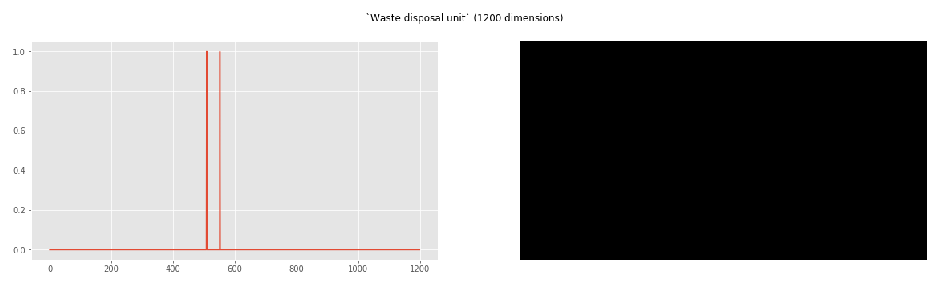

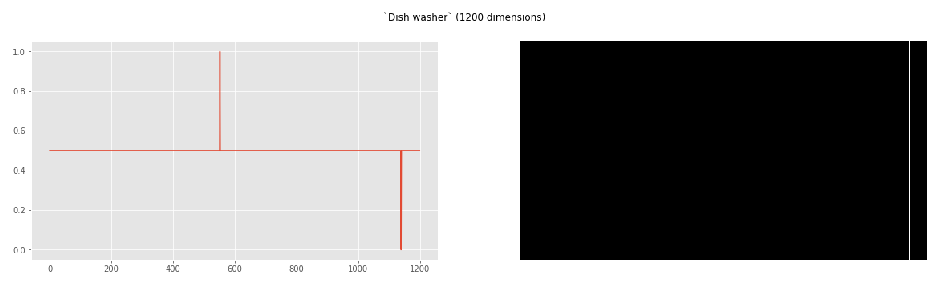

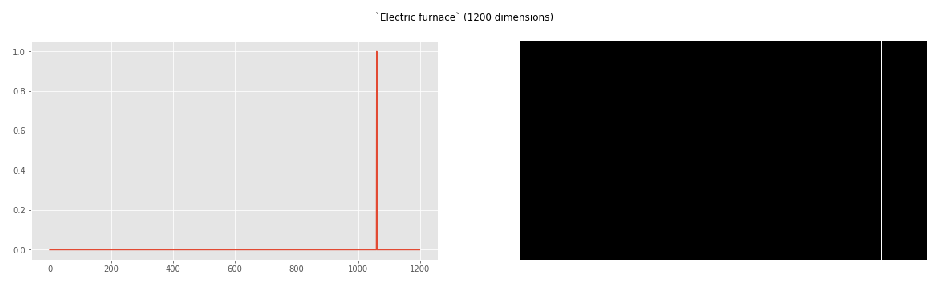

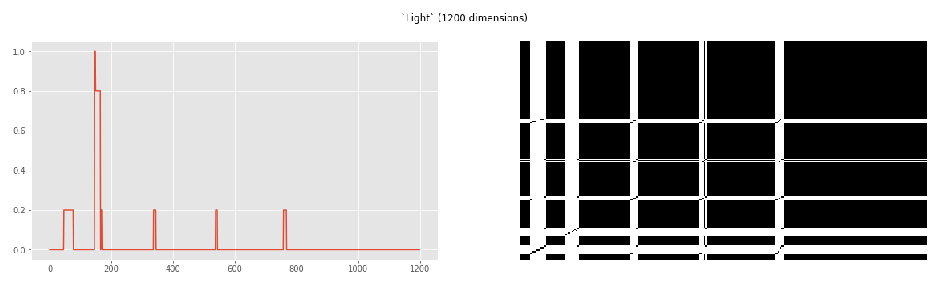

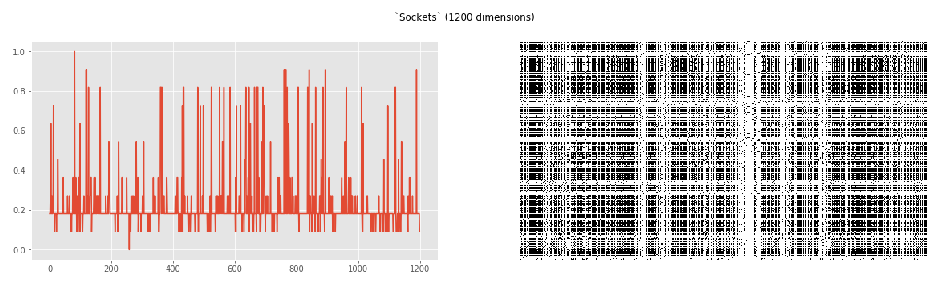

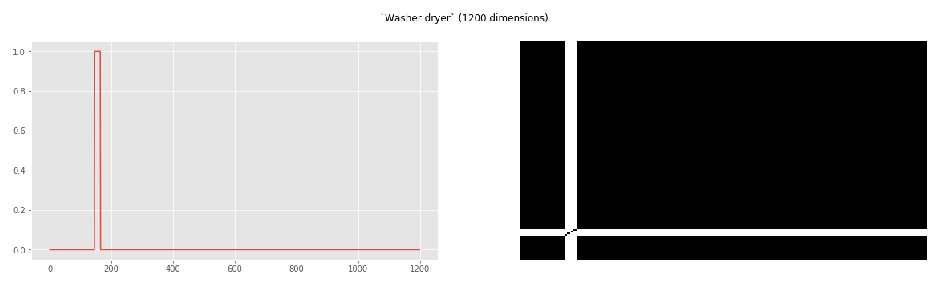

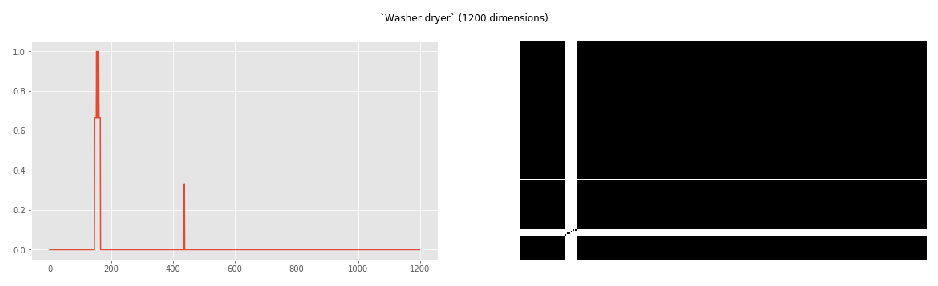

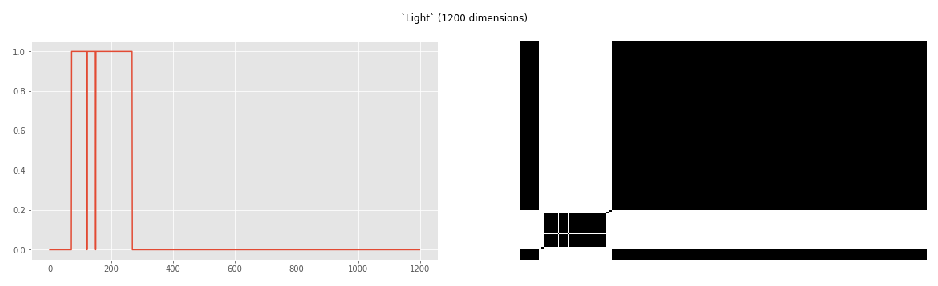

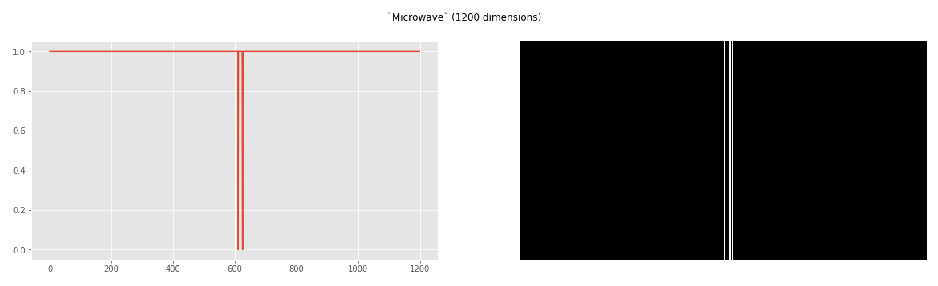

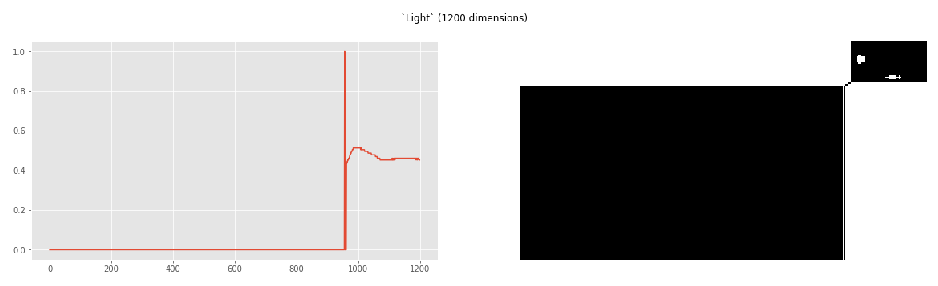

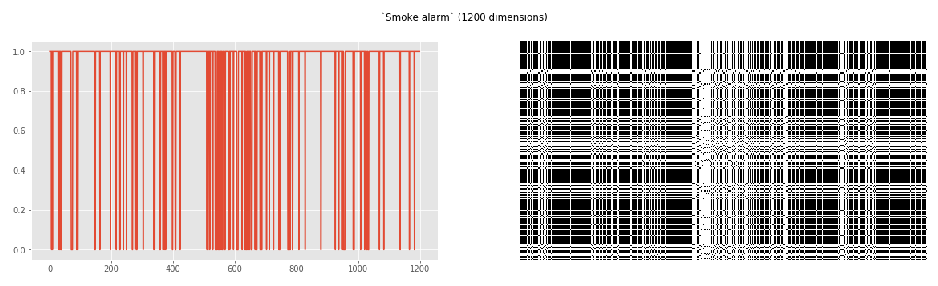

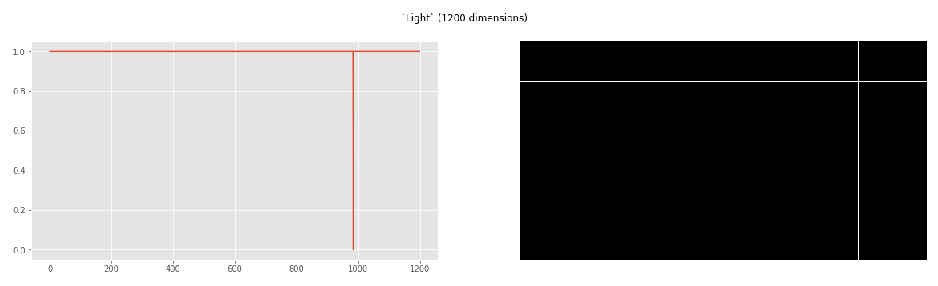

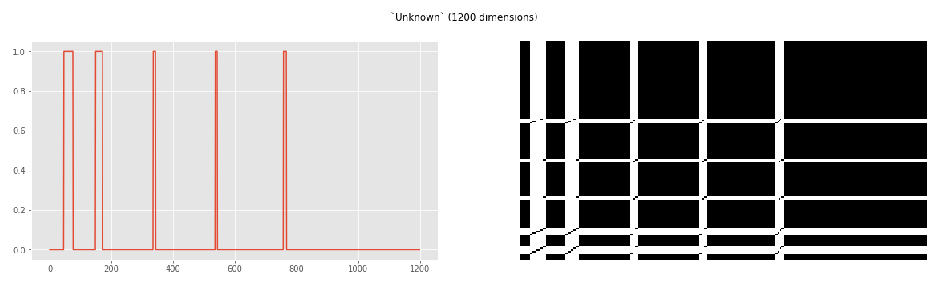

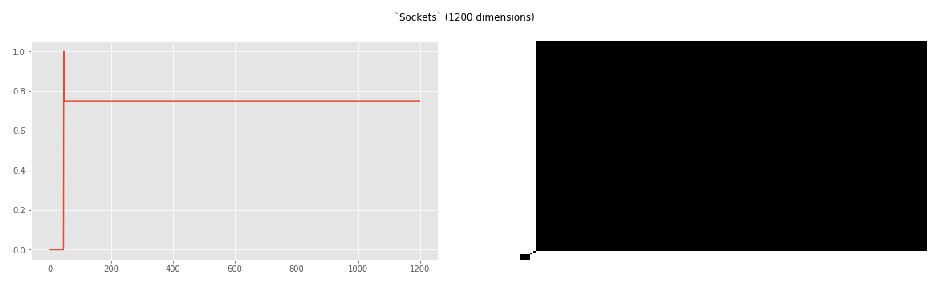

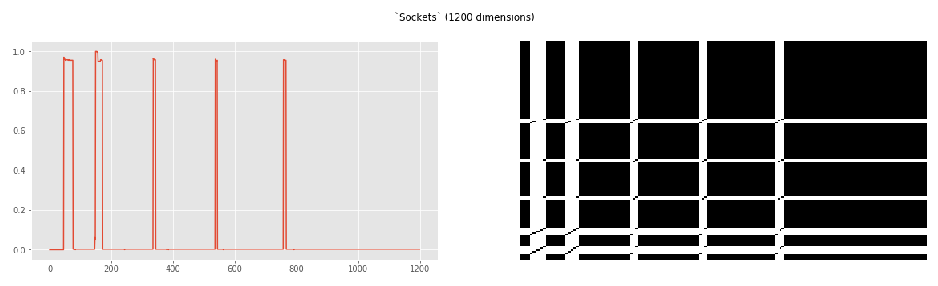

In [164]:
# Plotting RP Window sample by Appliance, and Calculating RQA by RPs.
# Turn interactive plotting off
plt.ion()
    
# for i, e in tqdm_notebook(enumerate(house_3.elec.submeters().meters)):
for e_i in tqdm_notebook(range(1, len(house_3.elec.all_meters())+2)):
    e = house_3.elec[e_i]
    appliance_images_path = os.path.join(images_path, str(e.instance())+"-"+e.label().lower().replace(" ","_"))

    image = plt.imread(os.path.join(appliance_images_path, "0.png"))

    fig = plt.figure(figsize=(20,5))
    plt.imshow(image)
    plt.axis('off')

In [163]:
# RQA Summary by Appliance...
df_rqa = pd.DataFrame(
    data = rqa_data,
    columns = ["Appliance", "Window"] + columns_rqa
)
#df_rqa.to_csv( os.path.join(windows_data_path, "df_rqa.csv"), index=False )
df_rqa.groupby('Appliance')[df_rqa.columns[5:]].mean()

,Recurrence rate (RR),Determinism (DET),Average diagonal line length (L),Longest diagonal line length (L_max),Divergence (DIV),Entropy diagonal lines (L_entr),Laminarity (LAM),Trapping time (TT),Longest vertical line length (V_max),Entropy vertical lines (V_entr),Average white vertical line length (W),Longest white vertical line length (W_max),Longest white vertical line length inverse (W_div),Entropy white vertical lines (W_entr),Ratio determinism / recurrence rate (DET/RR),Ratio laminarity / determinism (LAM/DET)
Appliance,,,,,,,,,,,,,,,,
CE appliance,0.281055,0.839994,16.959089,167.185714,0.014603,2.123188,0.898568,29.280829,180.035714,2.283722,34.922450,1090.942857,0.000931,2.766436,3.522638,1.080243
Dish washer,0.708535,0.975532,43.911716,438.903704,0.003179,2.775245,0.987522,83.275755,436.185185,1.897567,83.519424,853.474074,0.001398,1.628738,1.715994,1.013944
Electric furnace,0.778679,0.982029,108.815371,666.288136,0.002143,3.349370,0.990436,213.570271,666.381356,1.567283,192.502494,929.415254,0.001150,1.609219,1.384021,1.010096
Fridge,0.527274,0.998920,131.176008,538.000000,0.002005,4.824935,0.999434,249.628490,507.557143,2.018542,226.957569,875.314286,0.001179,2.152683,1.969663,1.000517
Light,0.681721,0.975239,112.129624,603.537473,0.002820,3.560806,0.986907,218.379927,596.156317,1.653128,163.052358,893.488223,0.001301,1.643922,1.787991,1.014612
Microwave,0.721095,0.963581,73.148731,611.726496,0.002445,2.858771,0.980872,142.673098,611.803419,1.685773,115.308928,954.897436,0.001171,1.776851,1.719388,1.020162
Site meter,0.424831,0.986700,100.994839,464.475000,0.003091,4.258179,0.991671,194.858860,443.407143,2.285493,188.151642,1039.950000,0.000984,2.539654,2.934101,1.005513
Smoke alarm,0.664925,0.930757,28.026783,363.264706,0.006524,2.400532,0.962021,53.863497,357.830882,1.933015,45.010309,814.897059,0.001436,1.756535,1.721798,1.042612
Sockets,0.683123,0.955160,71.293411,533.456929,0.005716,2.981594,0.973115,137.377243,528.949438,1.651761,121.206481,837.308989,0.001415,1.760868,1.764095,1.032686


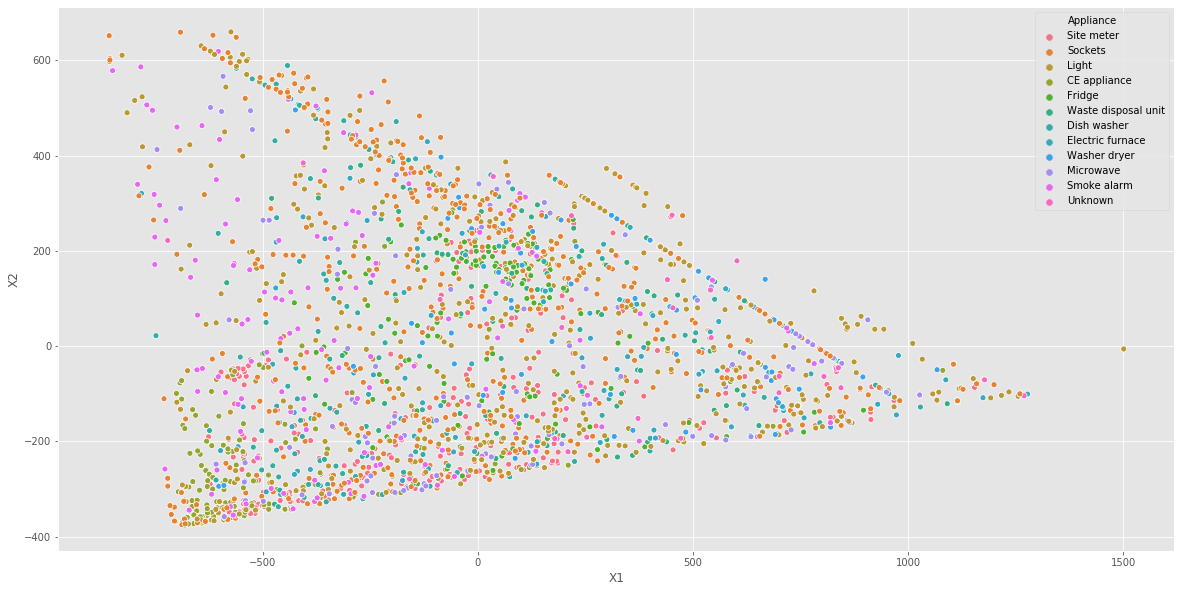

In [203]:
import seaborn as sns

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_projected = pca.fit_transform(df_rqa[ df_rqa.columns[5:] ])

df_projected = pd.concat([
    pd.DataFrame(X_projected, columns=["X1","X2"]), 
    df_rqa["Appliance"]], axis=1)
fig = plt.figure(figsize=(20,10))
sns.scatterplot(x="X1", y="X2", hue="Appliance", data=df_projected);

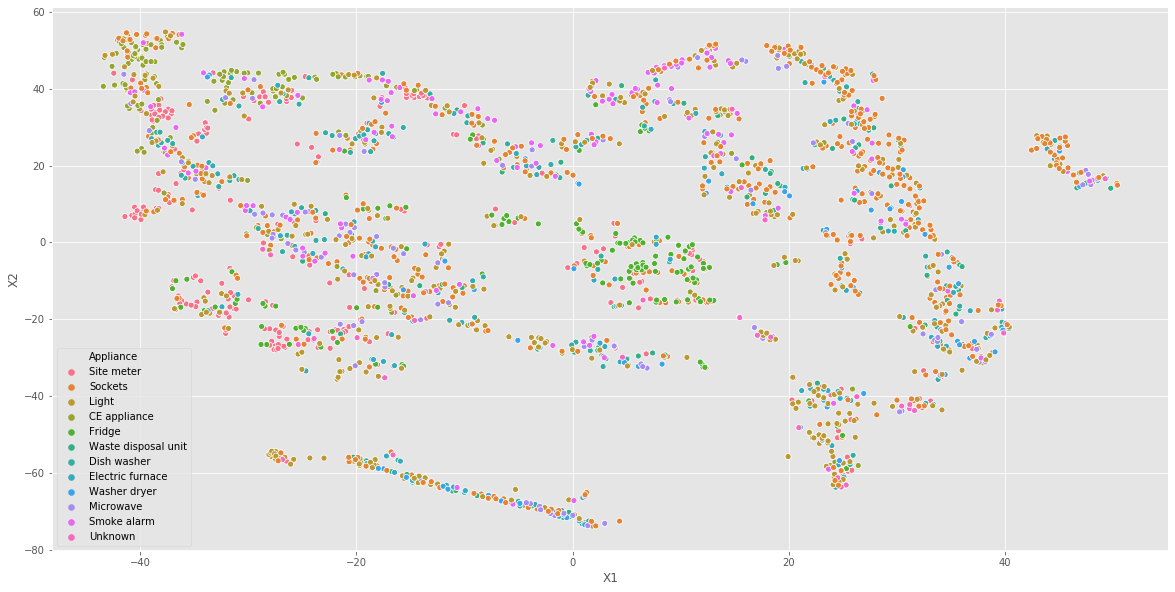

In [204]:
from sklearn.manifold import TSNE

X_projected = TSNE(n_components=2).fit_transform(df_rqa[ df_rqa.columns[5:] ])

df_projected = pd.concat([
    pd.DataFrame(X_projected, columns=["X1","X2"]), 
    df_rqa["Appliance"]], axis=1)
fig = plt.figure(figsize=(20,10))
sns.scatterplot(x="X1", y="X2", hue="Appliance", data=df_projected);

## Split Serie into Chunks (window samples)

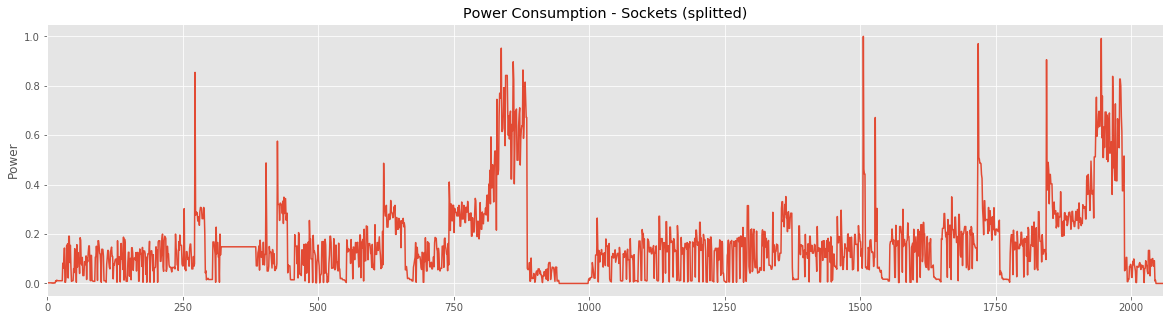

In [224]:
e = house_3.elec.submeters().meters[0]

data = np.array(e.power_series_all_data(sample_period=sample_rate).values[:series_limit])
data = scale(np.where(np.isnan(data), 0, data), out_range=(0, 1))

plot_serie(
    np.concatenate([
        data[105390:106350],
        data[155485:156585]
    ]), e.label()+" (splitted)")

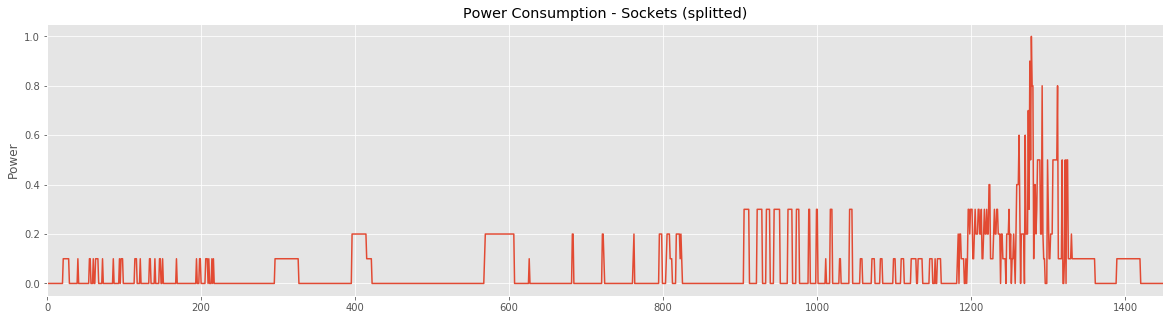

In [258]:
e = house_3.elec.submeters().meters[1]

data = np.array(e.power_series_all_data(sample_period=sample_rate).values[:series_limit])
data = scale(np.where(np.isnan(data), 0, data), out_range=(0, 1))

plot_serie(
    np.concatenate([
        data[1250:1500],
        data[3600:3800],
        data[36300:37000],
        data[106100:106400]
    ]), e.label()+" (splitted)")

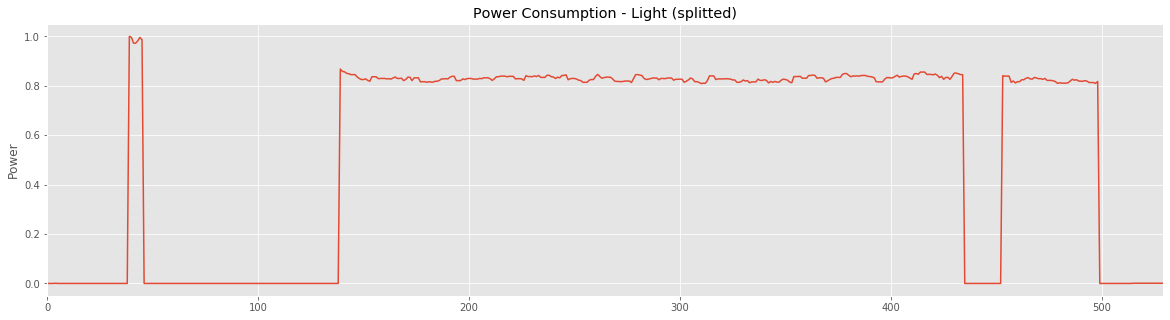

In [277]:
e = house_3.elec.submeters().meters[2]

data = np.array(e.power_series_all_data(sample_period=sample_rate).values[:series_limit])
data = scale(np.where(np.isnan(data), 0, data), out_range=(0, 1))

plot_serie(
    np.concatenate([
        data[70550:71080]
    ]), e.label()+" (splitted)")

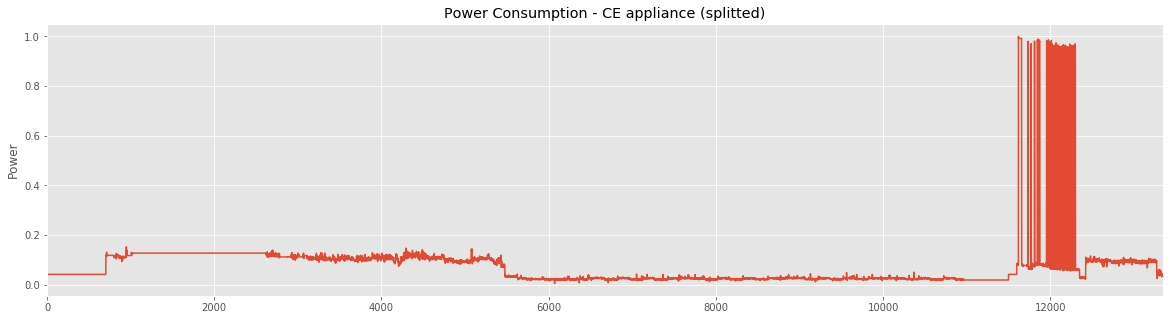

In [313]:
e = house_3.elec.submeters().meters[3]

data = np.array(e.power_series_all_data(sample_period=sample_rate).values[:series_limit])
data = scale(np.where(np.isnan(data), 0, data), out_range=(0, 1))

plot_serie(
    np.concatenate([
        data[10000:21500],
        data[36300:37150],
        data[40300:41300]
    ]), e.label()+" (splitted)")

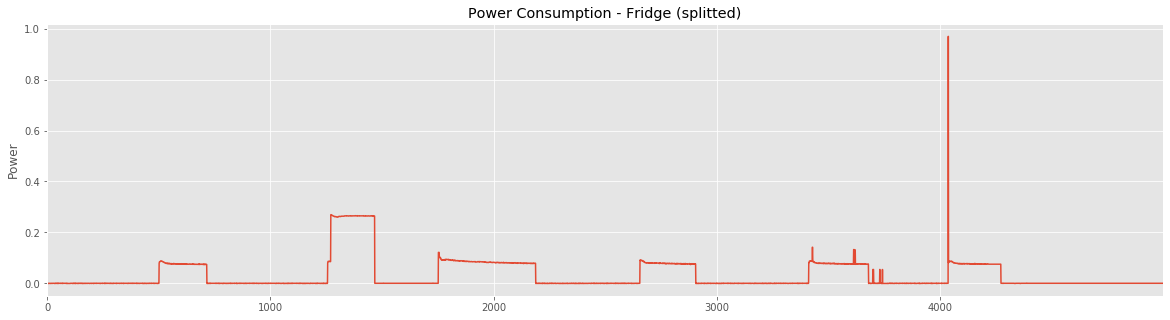

In [318]:
e = house_3.elec.submeters().meters[4]

data = np.array(e.power_series_all_data(sample_period=sample_rate).values[:series_limit])
data = scale(np.where(np.isnan(data), 0, data), out_range=(0, 1))

plot_serie(
    np.concatenate([
        data[0:5000]
    ]), e.label()+" (splitted)")

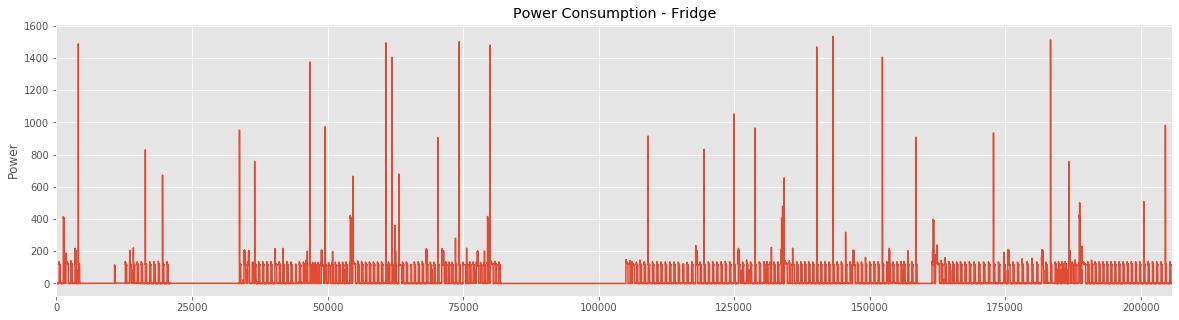

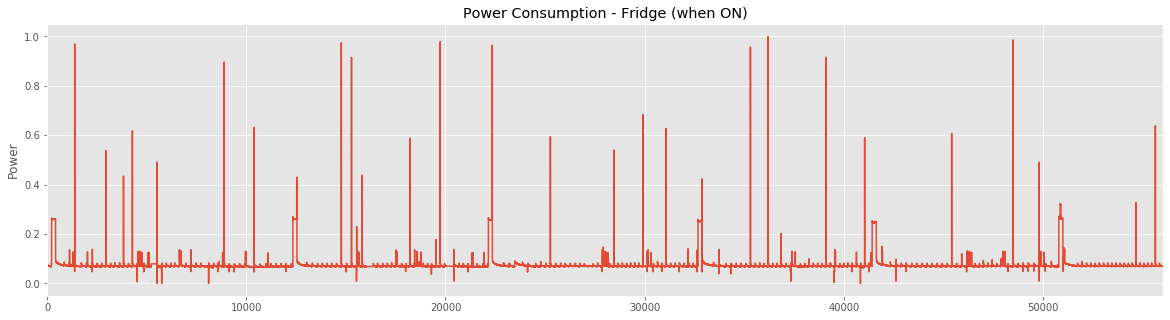

In [350]:
e = house_3.elec.submeters().meters[4]


power = e.power_series_all_data(sample_period=sample_rate)
#power.values = scale(np.where(np.isnan(power.values), 0, power.values), out_range=(0, 1))

plot_serie(power.values, e.label())

when_on = next(e.when_on(sample_period=sample_rate))
power_on = power[when_on == True].values
power_on = scale(np.where(np.isnan(power_on), 0, power_on), out_range=(0, 1))
plot_serie(power_on, e.label()+" (when ON)")

## Generating RPs from Window Consumption, by Appliance

In [ ]:
for appliance in appliances_power_windows:
    serie = np.mean(appliance["data"], axis=0)
    serie = scale(serie)#(serie - serie.min()) / (serie.max() - serie.min()) #scaling...
    
    #dim(m)= 1, thres(ε) = 0.2 (A, C, D) and m= 4, td = 9, ε = 0.4
    
    for d in [1,2,3,4,5]:#[1, 2,3,4,5,6,7,8,9,10,11,12,13]:
        for td in [None, 1,2,3,4,5,6,7,8,9]:
            for thres in [0.2,0.4,5]:
                
                try:
                    rp_image = RecurrencePlot(
                                    dimension=d,
                                    time_delay=td,
                                    threshold=thres, # Limiar de recorrencia
                                ).fit_transform([serie])[0]#(X.values)[0]

                    fig = plt.figure(figsize=(15,5))
                    fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

                    ax = fig.add_subplot(1, 2, 1)
                    plt.plot(list(range(0, serie.shape[0])), serie)
                    plt.xlim(0, window_length-1)
                    ax = fig.add_subplot(1, 2, 2)
                    ax.imshow(rp_image, origin="lower", aspect="auto", cmap="binary")

                    plt.axis('off')

                    fig.suptitle("{} (dim={}, delay={}, threshold={})".format(appliance["label"], d, td, thres), fontsize="x-large")
                except:
                    pass
    break

In [131]:
np.where(np.isnan(data), 0, data)

11688060.0

In [23]:
# for e_i in range(0, len(house_3.elec.submeters().meters)):
appliances_data = []
for e in house_3.elec.submeters().meters:
    
    #e = house_3.elec[e_i]
    serie = np.array(e.power_series_all_data(sample_period=sample_rate).values[:series_limit])[:interval]
#     serie = e.when_on()
#     print(serie.shape)
#     serie = X.values[2]
    serie = MinMaxScaler().fit_transform(
                            np.where(np.isnan(serie), 0, serie).reshape(-1, 1)
                        )[:, 0]

    rp_image = RecurrencePlot(
                    dimension=2,
                    time_delay=8,
                    threshold=0.2,            
                ).fit_transform([serie])[0]#(X.values)[0]
    
    fig = plt.figure(figsize=(20,5))
    fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

    ax = fig.add_subplot(1, 2, 1)
    plt.plot(list(range(0, serie.shape[0])), serie)
    ax = fig.add_subplot(1, 2, 2)
    ax.imshow(rp_image, cmap="binary", origin="lower", aspect="equal")
    #ax.quiverkey(rp_image)
    
    
    plt.axis('off')
    
    fig.suptitle(e.label(), fontsize="x-large")
    break

In [69]:
# Taxa (segundos) * 20 * minutos * horas
interval = 3*20 * 30 #*24 #(taxa * 20 = 1 minuto...) = 30 minutos
interval

1800

In [23]:
# import pandas as pd
# X=pd.read_csv('paper_anderson/disturbances.csv',sep=',', header=None)
# X.values

Loading data for meter ElecMeterID(instance=13, building=3, dataset='REDD')      ElecMeterID(instance=14, building=3, dataset='REDD')     
Done loading data all meters for this chunk.


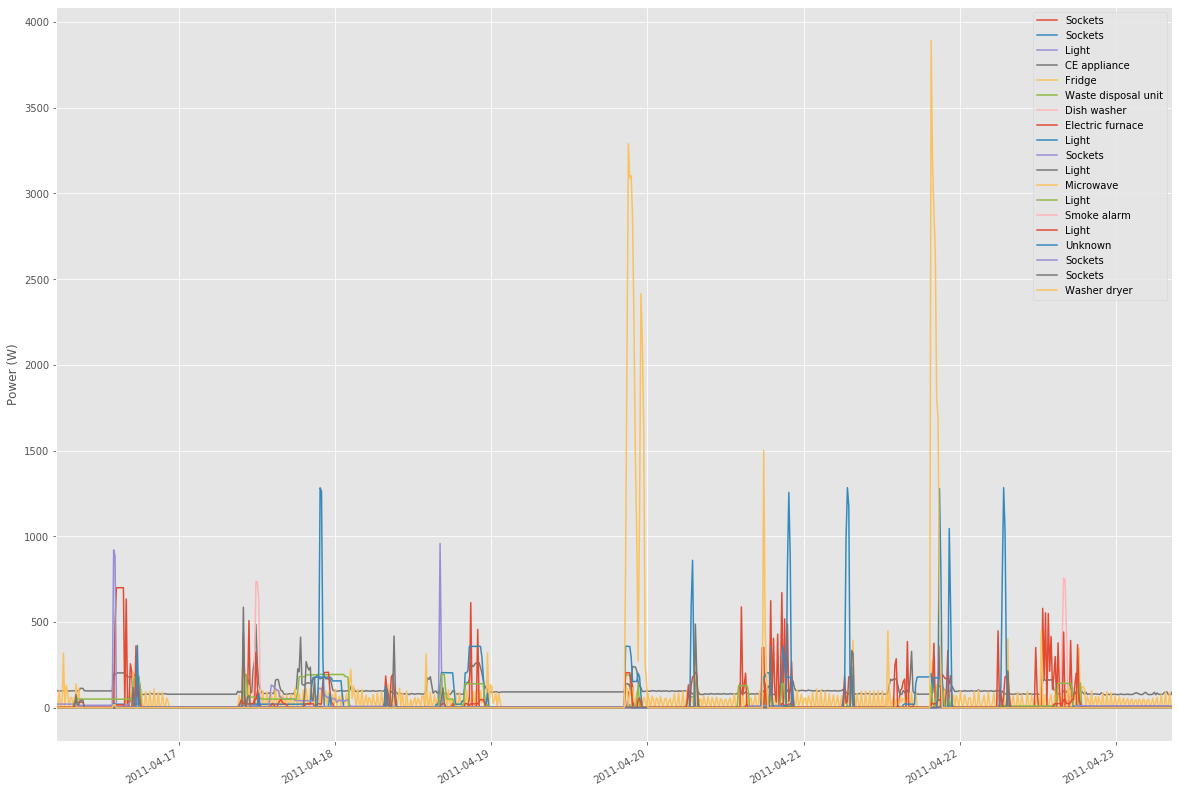

In [25]:
fig = plt.figure(figsize=(20, 15))
house_3.elec.submeters().plot();

Loading data for meter ElecMeterID(instance=13, building=3, dataset='REDD')      ElecMeterID(instance=14, building=3, dataset='REDD')     
Done loading data all meters for this chunk.


<Figure size 432x288 with 0 Axes>

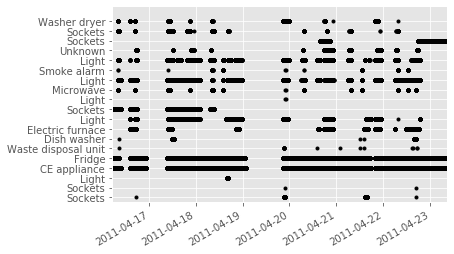

In [30]:
fig = plt.figure();
ax = house_3.elec.submeters().plot_when_on();
#fig.set_figheight(10);

In [21]:
# e = house_3.elec.submeters().meters[0]

# power = e.power_series_all_data(sample_period=sample_rate)
# when_on = next(e.when_on(sample_period=sample_rate))

# # fig = plt.figure(figsize=(20,15))
# # plt.plot(power)#[when_on == True]);

# rp_image = RecurrencePlot(
#                 dimension=2,
#                 time_delay=8,
#                 threshold=0.2,            
#             ).fit_transform([power.values[:int(power.shape[0]/3)]])[0]#(X.values)[0]

In [22]:
# for e in house_3.elec.submeters().meters:
#     serie = np.array(e.power_series_all_data(sample_period=sample_rate).values)#[:series_limit])[:interval]
    
#     fig = plt.figure(figsize=(20,5))
#     fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
#     plt.plot(list(range(0, serie.shape[0])), serie)
#     plt.axis('off')
#     fig.suptitle(e.label(), fontsize="x-large")